# Optimisation : Placer la plus grande maison possible dans un terrain

- La maison est un rectangle
- Le terrain est un polygone quelconque, il peut être convexe ou concave
- L'optimisation peut être faite en utilisant les algorithmes PSO, DE ou ABC

In [1]:
from sympy.geometry import Point
from sympy.geometry import Polygon as SympyPolygon
from scipy import *
from math import *
import sys
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Polygon
import pyclipper
import functools

from IPython.display import Markdown, display, HTML
def printmd(string):
    display(Markdown(string))

## Class and converting functions

In [2]:
class Rectangle:
    """Minimal representation of a rectangle"""
    def __init__(self, point1_x, point1_y, point2_x, point2_y, longueur):
        self.point1_x = point1_x
        self.point1_y = point1_y
        self.point2_x = point2_x
        self.point2_y = point2_y
        self.longueur = longueur
        
    def side_length(self):
        return dist((self.point1_x, self.point1_y), (self.point2_x, self.point2_y))
    
    def area(self):
        return abs(self.side_length() * self.longueur)
    
    def to_rect(self, strategy="Default"):
        """Convert a minimal rectangle to a full rectangle"""
        vect = (self.point2_x - self.point1_x, self.point2_y - self.point1_y)
        distance = self.side_length()
        vectUnitaire = (vect[0] / distance * self.longueur, vect[1] / distance * self.longueur)
        normalVect = (-vectUnitaire[1], vectUnitaire[0])
        point1 = (self.point1_x, self.point1_y)
        point2 = (self.point2_x, self.point2_y)
        point3 = (self.point2_x + normalVect[0], self.point2_y + normalVect[1])
        point4 = (self.point1_x + normalVect[0], self.point1_y + normalVect[1])
        if strategy == "Default":
            return [point1, point2, point3, point4]
        else:
            return SimpyPolygon(point1, point2, point3, point4)
      
    def is_valid(self, polygon, verbose=False):
        """ Determine if the rectangle is in the polygon

        @param polygon: whether a polygon or a list of vertices
        """
        if verbose:
            print("entrée: est_valide")
            start_time = time.time()
        try:
            rectangle = self.to_rect()
            pc = pyclipper.Pyclipper()
            pc.AddPath(polygon, pyclipper.PT_CLIP, True)
            pc.AddPath(rectangle, pyclipper.PT_SUBJECT, True)

            intersections = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)

            res = (intersections != []) and (len(intersections[0]) == len(rectangle)) and np.all([vertice_in_polygon(v, intersections[0]) for v in rectangle]) 
            if verbose:
                print("--- %s seconds ---" % (time.time() - start_time))
            return res
        except pyclipper.ClipperException:
            if verbose:
                print("Clipper exception")
            return False

### Util functions

In [3]:
def vertice_in_polygon(vertice, polygon):
    """ Determine if the vertice is in the polygon
    Not a strict check because of the pyclipper library in which
    the coordinates are floored.
    """
    x, y = vertice
    x, y = int(x), int(y)
    return [x,y] in polygon

## Drawing functions

In [4]:
COLORS_LEGEND_MAP = {"Swarm": "purple", "Best": "blue", "Best final": "blue", "Land": "green"}

def draw_polygon(polygon, ax=None, color="green"):
    """Draw a polygon over an axis (not shown directly)
    
    @param polygon: Whether a polygon or a path
    """
    if ax is None:
        ax = plt.gca()
    if type(polygon) == SympyPolygon:
        polygon = np.array(list(map(lambda p: [p.x, p.y], polygon.vertices)))
    p = Polygon(polygon, closed=False, color=color, alpha=0.3, lw=0)
    ax.add_patch(p)
    ax.axis('equal')
    return ax

def draw_polygons(polygons, colors=None, verbose=False):
    """Draw polygons and print the figure
    
    @param polygons: SimpyPolygon or list(SympyPolygon)
    @param colors: colors to match to the polygons
    """
    ax = plt.gca()
    if type(polygons) == SympyPolygon:
        polygons = [polygons]
    if colors is None:
        colors = ["grey"]*len(polygons)
    if len(colors) > 0 and len(colors) < len(polygons):
        colors = colors + [colors[-1]] * (len(polygons) - len(colors))
    colors.reverse()
    
    colors = deepcopy(colors)
    for polygon in polygons:
        color = colors.pop()
        if verbose:
            print(color, "Polygon : ", polygon)
        ax = draw_polygon(polygon, ax, color=color)
    return ax

In [5]:
def create_animation(legend, land):
    fig, ax = plt.subplots()
    
    ax = draw_polygons([land], colors=[COLORS_LEGEND_MAP["Land"]])
    log_frames = LOGS[legend]
    n_frames = len(log_frames)
    
    def update(i):
        log_frame = log_frames[i]

        sols = log_frame['polygons']
        polygons = [Rectangle(*sol).to_rect() for sol in sols]
        ax.clear()
        draw_polygons([land]+polygons, colors=[COLORS_LEGEND_MAP["Land"], COLORS_LEGEND_MAP[legend]])
        ax.set_title(log_frame['title'])
        return fig,

    anim = animation.FuncAnimation(fig, update, frames=n_frames, blit=True)
    anim = HTML(anim.to_html5_video())
    plt.close()
    return anim

## Lambda functions to use in the calls

### Logger function

In [6]:
LOGS = {}
    
def log_polygons(land, sols, colors=["green", "brown"], legend="Best", text="", padding=1, iteration=0, fitness=None, beautify=True, show=True):
    if (iteration % padding == 0):
        if not legend in LOGS.keys():
            LOGS[legend] = []
        sols = list(sols) if type(sols) == map else [sols]
        title = "Itération " + str(iteration)
        title += " : " + legend if legend is not None else ""
        title += " = " + text if text is not None else ""
        polygons = [land]+[Rectangle(*sol).to_rect() for sol in sols]
        
        if show:
            ax = plt.gca()
            ax = draw_polygons(polygons, colors)
            if beautify:
                printmd("### "+ title)
            else:
                ax.set_title(title)
            plt.show()
            
        log_to_append = {"polygons": sols, "title": title, "iteration": iteration}
        if legend.startswith("Best"):
            log_to_append['fitness'] = fitness
        LOGS[legend].append(log_to_append)

### Bounding function

In [47]:
def polygon_bounding(sol, land_polygon, verbose=False):
    if verbose:
        print("entrée: polygon_bornage")
    solution = Rectangle(*sol)
    if solution.is_valid(land_polygon):
        if verbose:
            print(sol)
            printmd("## Est valide")
        return sol 
    else:
        if verbose:
            print("this one is invalid")
        # print(sol)
        raise ValueError("Solution invalide par contrainte de bornage")

## Initialization function

In [8]:
from sympy import Symbol
def pick_random_sol(land, size=1, delta=0.05, stochastic=False, strategy="random", inf=0, sup=200):
    if strategy == "random":
        sols = []
        for _ in range(size):
            sol = random.uniform(inf,sup,5)
            rect = Rectangle(*sol)
            while not rect.is_valid(land):
                sol = random.uniform(inf,sup,5)
                rect = Rectangle(*sol)
            sols.append(sol)
        return sols
    else:
        t = Symbol('t', real=True)
        p = SympyPolygon(*land).arbitrary_point('t')
        if stochastic:
            picks = sorted([random.rand() for i in range(size*2)])
        else:
            picks = np.linspace(0, 1, size*2+1)
        points_on_perimeter = [p.subs(t, pick) for pick in picks]
        sols = [[points_on_perimeter[i*2].x, points_on_perimeter[i*2].y, points_on_perimeter[i*2+1].x, points_on_perimeter[i*2+1].y, -10-delta*2000*random.rand()] for i in range(size)]
        for sol in sols:
            while not Rectangle(*sol).is_valid(land):
                sol[4] = sol[4] / 2
        return sols

def get_border_search_field(polygon):
    min_func = lambda acc, vertice: min(min(*vertice),acc)
    max_func = lambda acc, vertice: max(max(*vertice),acc)
    
    min_search_field = functools.reduce(min_func, polygon, sys.maxsize)
    max_search_field = functools.reduce(max_func, polygon, -sys.maxsize)
    
    return min_search_field, max_search_field

# Main

In [9]:
poly1 = [(0,0), (0,100), (100,100), (110, 50), (100, 0)]
poly2 = [(0,0), (0,100), (30,90), (30,40), (71,25), (71,100), (100,100), (100,0)]
poly3 = [(0,0), (0,100), (30,90), (30,10), (71,25), (71,100), (100,100), (100,0)]
poly4 = [[10,10],[10,400],[400,400],[400,10]]
poly5 = [[10,10],[10,300],[250,300],[350,130],[200,10]] 
poly6 = [[50,150],[200,50],[350,150],[350,300],[250,300],[200,250],[150,350],[100,250],[100,200]]
poly7 = [[50,50],[50,400],[220,310],[220,170],[330,170],[330,480],[450,480],[450,50]]

### L'aire du terrain est de **81100** m²



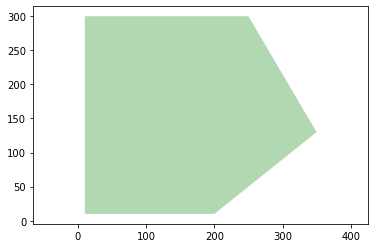

In [10]:
LAND = poly5
draw_polygon(LAND, color=COLORS_LEGEND_MAP["Land"])
printmd(f"### L'aire du terrain est de **{abs(SympyPolygon(*LAND).area)}** m²\n\n")

In [11]:
from ipynb.fs.full.PSO import fit as PSO_fit

In [55]:
LOGS = {}
DIM = 5

ACCEPT_WHEN_INVALID_MOVE = False
NB_PARTICLES = 100
NB_CYCLES = 1000
PSI, CMAX = 0.4, 1.47

LOG_PADDING = 50
INF, SUP = get_border_search_field(LAND)

if ACCEPT_WHEN_INVALID_MOVE:
    eval_function = lambda x: (
        rect := Rectangle(*x),
        rect.area() if rect.is_valid(LAND) else -rect.area())[-1]
    bounding_function = lambda x: x
else:
    eval_function = lambda x: Rectangle(*x).area()
    bounding_function = lambda x: polygon_bounding(x, LAND)
    
log_function = lambda x, it=0, fitness=None, legend=None, text=None, padding=LOG_PADDING, colors=["green", "red"]: (
    log_polygons(LAND, x, colors, legend, text, padding, it, fitness, show=False))

init_function = lambda nb: pick_random_sol(LAND, nb, inf=INF, sup=SUP)
isbetter_function = lambda f1, f2: f1 > f2

In [48]:
best_sol = PSO_fit(eval_function=eval_function, 
    bounding_function=bounding_function, 
    log_function=log_function,
    init_function=init_function,
    isbetter_function=isbetter_function,
    nb_particle=NB_PARTICLES, 
    dim=DIM, 
    nb_cycles=NB_CYCLES,
    psi=PSI,
    cmax=CMAX)

  0%|          | 0/1000 [00:00<?, ?it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[213.83596466856466, 276.7567050483301, 133.12152065906275, 263.94825076115137, 71.98996352243793]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[163.04420399938815, 147.62533224489465, 92.11092679039987, 177.47277587861268, 120.78795249405078]


## Est valide

entrée: polygon_bornage
[290.2825098741512, 149.04615924264039, 43.682295851345295, 217.29522694744645, 49.71446575507053]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[256.7650339526788, 206.0976274942168, 84.98383603957146, 269.67816820624415, 115.13392905912409]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[183.09722871268778, 291.3701346207352, 23.83757133966475, 221.78067308343307, 67.09688822368841]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[227.30155865703225, 281.22565125857744, 155.848097272696, 272.4832769454917, 54.626479446681905]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[230.89652202533384, 287.7985151968201, 60.218968180023154, 238.9326833740465, 175.5365095416036]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[108.16740358391012, 277.13152353831964, 48.48389483192206, 217.5908839958689, 133.09027350746842]


## Est valide

entrée: polygon_bornage
[249.11439455444224, 254.19926836691587, 79.42310271870866, 264.6157735575344, 73.0137945831591]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[169.93461757512443, 261.6696360625896, 77.79294252151577, 278.9977299862677, 175.3803548294356]


## Est valide

entrée: polygon_bornage
[244.94293755422737, 225.30103564507402, 59.9719447343637, 242.63358849090008, 82.67703016880395]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[225.1268848290243, 278.98602650722177, 44.40192164999695, 280.37499317803145, 200.99516001733323]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[258.9324329518783, 267.38481465888356, 31.247449725733418, 191.82855290613017, 90.87154108268629]


## Est valide

entrée: polygon_bornage
[224.18675058754314, 265.2283855918374, 78.46173018108178, 292.72189114119533, 40.48123989285518]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[238.37704246340115, 283.873173772921, 61.30523917157787, 240.17345351825162, 199.8915316493149]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[258.10906575839107, 282.1119388608107, 61.04596193891665, 268.5457480634527, 195.36395090322162]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.9405861536835, 278.9427368696227, 102.46569544882145, 201.34841023233702, 141.32067361273332]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[252.19737457599484, 187.22279447846662, 27.305162281103065, 218.502907601149, 87.10730378439385]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[204.58974201971472, 267.7868819658963, 54.099931924056705, 226.82939831126387, 109.4981596590916]


## Est valide

entrée: polygon_bornage
[252.21296598269993, 245.02904471395865, 125.00377506225496, 266.50608963488475, 195.43641775811346]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[196.0021729194192, 279.88752019218384, 65.17838087085336, 268.7577694680272, 145.40176317271616]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[203.3664765210557, 271.00501142983154, 62.090619653140536, 243.89182650443172, 168.71391800753446]


## Est valide

entrée: polygon_bornage
[174.6836451414971, 280.4589079013242, 54.933836304684746, 235.11514215240373, 194.4718068027236]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[259.92641531503534, 225.62831092295391, 198.0304235205453, 268.1371105389876, 124.69971590762857]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[126.99404010366047, 292.0007244455478, 58.620871188521775, 266.88365401952257, 163.34829498326542]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[203.27075032795722, 285.2620411594223, 52.48210682239362, 220.62368410732591, 146.5731130962722]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[165.37039786337021, 281.0477336222066, 25.097751534009547, 242.57868746273948, 103.62513180364903]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[305.45925915410874, 143.8823961845132, 216.70674772699277, 270.7671339721022, 172.4604921737698]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[196.07839270915633, 140.12289246394715, 86.54988584353828, 160.74702611232632, 37.909779172839755]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[183.19562174865558, 60.438250901238575, 152.7629230000829, 294.6842180910139, 135.91218492114734]


## Est valide

entrée: polygon_bornage
[106.90932617110877, 278.68317481400646, 78.59861015984106, 268.1089188749587, 162.89400692483292]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[206.36261446562258, 275.6511400537013, 63.95972668288044, 240.66275677083914, 186.15617450357885]


## Est valide

entrée: polygon_bornage
[212.61579335582246, 261.25897953056904, 40.0568151119588, 249.9568553640956, 171.7639460179819]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[186.20461748785175, 265.64774778595825, 73.9693359098261, 255.72830012506256, 199.61172363448884]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.495683365704, 295.90636253923526, 78.90384198681477, 280.771426263945, 143.28497689149367]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[111.67417497524968, 274.8143402955963, 61.38469877796517, 279.63063706407365, 159.85316114370525]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[258.10906575839107, 282.1119388608107, 61.04596193891665, 268.5457480634527, 195.36395090322162

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[259.6278566127863, 261.66863392847574, 106.87198662974899, 263.82126359885757, 196.04232402062107]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[209.07778878650416, 279.41340519076664, 63.24288103372014, 246.87775024404522, 193.58303351563964]


## Est valide

entrée: polygon_bornage
[85.31015622794672, 281.52021802163125, 78.57043012303637, 237.93780189983033, 183.97213390713645]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[262.64882506558797, 274.20617271843776, 139.27331548563458, 244.22454049704092, 159.12421285082186]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[274.30456772483916, 208.03907521425606, 225.7617922400598, 271.28327955207436, 196.72496697064938]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[161.39416946354987, 280.61817267572286, 73.82204921124367, 294.92396305098373, 150.71268246577216]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[240.57612104088412, 262.2266956651482, 65.49931381473922, 287.67297711741156, 199.96421684128245]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[258.10906575839107, 282.1119388608107, 61.04596193891665, 268.5457480634527, 195.36395090322162

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[262.1818925954686, 277.65954335689025, 69.4426754908131, 264.687419589472, 196.17324945896053]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[242.95892703812825, 280.65567997839116, 63.449881444277786, 279.03487807758495, 193.38048443099257]


## Est valide

entrée: polygon_bornage
[126.74235704825489, 285.41562480213764, 20.670424217083934, 280.0292261221833, 191.52841636852895]


## Est valide

  0%|          | 3/1000 [00:00<00:40, 24.73it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[254.53745733537318, 286.04034874878755, 63.2953857364327, 256.619259683499, 186.6716074314445]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[254.96916525072538, 280.6647820504394, 140.18978207606028, 273.8156264694154, 193.77147093275119]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[194.40521953611457, 186.59615285611605, 82.61506070107644, 259.4802698069908, 115.9789882555097

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[248.22152202281478, 278.52543583305885, 52.826050620206445, 296.24510000401085, 224.78455741945012]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[261.7443795123106, 282.260194680887, 63.013810676294625, 280.7729179331905, 195.42796180697502]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[258.10906575839107, 282.1119388608107, 61.04596193891665, 268.5457480634527, 195.36395090322162]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.74154416822475, 292.4468771723367, 50.695645699054495, 295.828914234036, 180.37876894092136]


## Est valide

entrée: polygon_bornage
[257.44606105551077, 284.5681339143729, 52.26411527860696, 270.60289318264694, 195.75752452932332]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[240.38061381329405, 284.51129307519113, 28.86668386877336, 290.6481633422437, 197.62839517803286]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[206.35079000008093, 286.76767880353765, 29.55429391385462, 255.9219088439009, 180.80638313740977]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[162.7123067084729, 41.83497320001243, 288.2366468079483, 207.67741188470603, 135.24271475427622]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[250.98909643971288, 212.58074754662886, 43.759910765727376, 253.5356298115016, 172.8573150958428]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[230.3753233290209, 277.7023800857589, 45.654900034671606, 148.2392898217815, 155.08179046359032]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.40851095763946, 231.54808945561552, 36.31522474772197, 232.99051978999765, 140.61294397362934]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[227.29960914447443, 264.5741876221854, 129.52373877488196, 195.18424924674133, 146.37066036421706]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[233.18520886047293, 285.2469187737484, 48.98199278953544, 198.65631775047638, 190.11507834931615]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[230.29693653095364, 208.54093336208604, 57.62817085921424, 176.21285179786292, 152.53918917198757]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.43090149459715, 257.9714842178215, 30.070014845355168, 247.53562174248276, 157.7117211048785]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[211.10746456471261, 248.20686216598455, 37.96864046578444, 241.13831400332234, 129.14870469455627]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[219.03807357070735, 281.2431835100068, 48.63554335198835, 208.75569022371346, 171.52638584572074]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[213.91059208421075, 278.15743071245447, 18.14227847174525, 188.3772190761414, 190.5637327631746]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[233.98792477567747, 217.41447150668938, 56.69295357057925, 234.30290633937958, 129.5790479549629]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.3123109817739, 281.116892729121, 37.50927839448668, 223.71511952609598, 183.5769415368095]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[196.2177081411541, 285.1280927986686, 47.402910234295774, 223.01530090498102, 168.68494542179334]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[258.04870289474616, 239.55124658526617, 169.3686750364252, 247.42015309618083, 92.2783840371142]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[193.33033614393503, 239.24122836533343, 11.999884831877978, 142.9233711685055, 139.37568114913]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.55992468958306, 236.87755286808178, 39.96599538643472, 201.81301744123692, 159.00550812965372]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[111.03089246406142, 231.21684668576248, 89.8046877448042, 224.03148739018732, 214.78060504793126]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.6105023593121, 239.2734445555105, 32.48953179049608, 230.84969067195027, 183.94113125148596]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[249.60929326172325, 264.421739721254, 46.70144559955592, 291.04745698779317, 223.1020989668084]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[253.3558538447464, 257.98691373157857, 46.17991275359219, 289.26194600027856, 202.07192673315274]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[230.77021109888796, 268.92419266903715, 33.80005150837336, 277.43149279739964, 209.343237061947]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[217.9435421251183, 244.9915511987513, 40.645984964606136, 267.267333052727, 193.41606376344015]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.69749846129363, 278.9397045490835, 31.53919083240877, 230.1054769898421, 198.3742586444704]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[249.88918824649505, 274.0233788803787, 32.62206931010578, 261.5783241848146, 187.72689432814636]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[223.61564634011836, 235.53297035530701, 63.81284535319796, 232.87478599802358, 167.93794506463172]


## Est valide

  1%|          | 6/1000 [00:00<00:39, 25.27it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[236.19688182306098, 275.3391579832233, 44.22393469587555, 257.9079999893032, 209.97319703915628]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[217.68440735020076, 275.21816729304487, 77.11452118014043, 208.89085532076442, 185.59933190867542]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.97356255046031, 271.37336872551, 32.58868969499268, 276.14461548110296, 146.95762313089077]


## Est valide

entrée: polygon_bornage
[229.98739746784585, 288.86992443221914, 57.98614944108145, 285.100801830388, 194.84434015209104]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[225.23519947368007, 243.89561120833446, 47.867598032327564, 264.16641152203044, 229.82145148242205]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[216.1056577970844, 278.33679736677186, 16.34470626280524, 282.4819184380897, 203.88082813588954]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[233.0588473666771, 268.87401847075165, 47.96703109669775, 294.45223858650814, 218.0383700625962]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[248.66204268995088, 269.7161920683153, 46.16970778337367, 283.7507106154917, 203.7428902306205]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[209.0053125874611, 270.48084326244685, 41.964398089565854, 267.0232922476243, 214.93728277101565]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[230.48452252098656, 257.75761006204056, 44.25350683035118, 283.3994749550241, 200.17981845076105]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[241.3825075369302, 264.74134289205847, 44.95785862713336, 278.2116070610126, 213.46801908410038]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[231.6337393301987, 265.6967880515236, 41.19236834696996, 260.59873079196876, 211.27157900616166]


## Est valide

entrée: polygon_bornage
[218.42308581504088, 275.2284912364721, 41.000196357109864, 283.1133781665096, 205.3838967720117]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[231.04426187531496, 283.5534155679105, 43.54298584609125, 259.0621725132984, 213.0998788867472]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[240.70236448137686, 259.4607994024621, 49.19760408862541, 253.83137281935404, 199.58638626799498]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.51312357860235, 281.9095946130274, 35.95236267077414, 291.9202912782198, 230.87804561933203]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[219.708495804052, 272.3239451703262, 39.55875179102701, 290.6923182730001, 234.1782274458148]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.86444444695624, 270.45286800562656, 33.628650363632545, 286.94856714952454, 208.5528606382643]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[248.69178803297834, 270.72082313207954, 44.19593785108977, 259.07280246726646, 177.50413569940713]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[196.23586200465394, 261.37550139182713, 27.36994215620943, 274.00904564365715, 206.8526110055236]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[192.60408984003024, 278.02895756408554, 49.242309033672065, 271.5922645651336, 193.09297136234252]


## Est valide

entrée: polygon_bornage
[217.5615689427256, 286.99831892485486, 38.27126139572223, 258.8243738446572, 208.2619903788438]


## Est valide

entrée: polygon_bornage
[210.20745258208018, 291.1811711932158, 30.686902765577035, 244.6403630929671, 204.98562446802842]


## Est valide

entrée: polygon_bornage
[220.9162839464131, 289.0321873498704, 40.641302113582086, 226.0204917188429, 201.01721174925433]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[222.29104022514025, 230.24791591042558, 31.737195376316425, 219.6177569534969, 142.9897474384226]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.74593746943728, 292.14275233771946, 16.09337076908045, 263.027790555332, 231.90905432615386]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[197.47555752569204, 283.466438492472, 13.709360295849343, 286.0605265431027, 192.5451760083642]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[201.68606856108477, 292.18345177604937, 34.50760590867485, 263.68237615698104, 205.34391094069954]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[208.76638699426618, 287.72777780585324, 47.86147336750515, 254.75701385554356, 194.03337366781233]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[196.12570478908881, 300.282456114546, 32.29267193616374, 269.0872753165831, 220.15188129977156]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[212.18808962598172, 282.3474518563896, 42.116284524057825, 255.61899991438392, 187.83456436822874]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[188.69525231620233, 283.6289143491663, 30.01641105615019, 282.08463276933276, 258.63556615694574]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[198.3868318886631, 283.12772186728665, 38.84543956210015, 290.558379637321, 204.07326144375932]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[217.30302197792764, 291.6391069885486, 32.722904249661354, 272.4629648697624, 197.25333122857919]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[218.7169126463532, 267.82217946309396, 32.40216060892482, 245.78025001737728, 208.9444416103175]


## Est valide

entrée: polygon_bornage
[213.81993012401193, 277.73262492403927, 27.329900314534104, 268.6535017140688, 195.20734696062948]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[215.31813114936588, 298.14455193528477, 30.051475673364205, 265.8579076908147, 189.17584077595663]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[220.77057131912164, 208.91932787732756, 35.15902214040721, 142.79720970566586, 122.75947019830738]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.15065509535012, 291.9801437031415, 17.63061880693793, 264.7539210900495, 187.4577996917298]


## Est valide

entrée: polygon_bornage
[218.68042936058316, 290.0426561121744, 33.367723113568935, 295.8083610228945, 190.40261864315607]


## Est valide

entrée: polygon_bornage
[202.03887303187156, 286.3303772649289, 22.725023897169308, 251.203819105411, 183.03605912889424]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[211.88320957420189, 291.1575621365045, 32.6198957662026, 287.5346799307051, 193.82611473530264]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[198.2200225118519, 282.4910203641937, 33.819687965326736, 263.58940649657626, 179.50413958557334]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[230.2937690061829, 278.53926836567854, 33.69674576529053, 263.13070967094967, 207.1278794563091]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[221.17428146498744, 286.58938746700096, 29.869055859499667, 293.3817521656613, 199.59843661409948]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.4233526119304, 273.4129504010101, 47.268660481636985, 283.1955969902675, 184.9910485053651]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[228.26663705289508, 294.03190600936506, 32.76237545331119, 280.3984035054644, 194.6839376750074]


## Est valide

entrée: polygon_bornage
[240.4091248008591, 276.80962816538465, 30.981422165755617, 276.577237482279, 124.58042540796801]


## Est valide

entrée: polygon_bornage
[228.91443368406686, 291.6433465682203, 32.933145028491914, 287.4268087589921, 154.5799936998738]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[231.78117370500166, 294.15851122857214, 27.95240206806134, 269.30972201917444, 234.74660904964028]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[226.0595828251096, 291.59789090993013, 26.854924763875985, 270.80678564247637, 150.22390476706704]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[230.22125087481857, 277.2407005460556, 14.867521482780678, 271.5720409505742, 175.6457528377314]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.70618982369226, 261.9415693832281, 28.58217876812925, 275.91811704528266, 192.7190970334602]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[214.59366501193085, 274.5108451344471, 40.75039256456519, 239.2669179587114, 120.52830195366074]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[230.55820382212158, 275.9154555728915, 30.37268755064842, 282.5690028291863, 208.99131102329136]


## Est valide

entrée: polygon_bornage
[156.5174274212037, 263.26512989610785, 10.75595080834404, 208.29853447889855, 162.48944201257686]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.87026844335952, 270.04896574522843, 20.819639924122406, 246.60729237860284, 114.71308866976904]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[221.29931143044777, 289.0468127414757, 14.90117210946832, 274.97982131818947, 202.34286145845704]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[233.68918703013122, 280.69711931245394, 38.62279048620692, 297.51318881887346, 151.56173782397022]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[217.57031667451827, 275.36666959202427, 23.989432576572526, 281.56968433415943, 189.30440940174853]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.42952137272266, 265.8585830431637, 34.05750677464597, 261.96448493789916, 129.72753493549257]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[227.06287527900153, 268.3090663123706, 35.80422735145814, 278.8817417050599, 192.25429845990237]


## Est valide

entrée: polygon_bornage
[225.4781085516368, 274.12109236107057, 31.06124565105712, 273.61084237788265, 132.0886471071975]


## Est valide

entrée: polygon_bornage
[153.7619898725613, 288.1766656389582, 23.19832863698528, 282.1008198619153, 219.91578170357423]


## Est valide

entrée: polygon_bornage
[231.33310300131907, 288.2899768832525, 27.86537519875833, 265.4660541163393, 176.02971378861082]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[200.6949974103207, 281.3535168335415, 44.50086791586825, 288.15402610834644, 235.01954355125724]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.82076902784482, 274.0835424302975, 42.03327255547718, 270.20955635384456, 200.04171827200594]


## Est valide

entrée: polygon_bornage
[254.91104379669338, 274.29664426095434, 33.14677066751801, 270.0702517857269, 175.7186008806656]


## Est valide

entrée: polygon_bornage
[250.974614845507, 288.4987998473752, 29.68133502897, 297.9690522601394, 152.21146893778797]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[218.96998705296, 279.7534794009506, 33.22465080955164, 271.610600169657, 195.81909067843597]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[252.07687025824336, 259.6874423149188, 33.414713812438045, 270.17505011070295, 160.60405064284905]


## Est valide

entrée: polygon_bornage
[247.21955329578745, 279.31029810600216, 27.043585716061898, 292.11309210212056, 165.31769449636636]


## Est valide

entrée: polygon_bornage
[223.71781415877098, 280.0829846884676, 29.139140786452312, 277.8221289196896, 199.0630304694152]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.2647280460896, 284.82444781460094, 35.301859124713246, 287.9949586104706, 218.00246428104475]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[217.54176104390552, 283.96013208158746, 52.5806211053726, 239.9388657030326, 171.11384569032705]


## Est valide

  1%|          | 9/1000 [00:00<00:40, 24.55it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[233.32443182592735, 296.40718276296684, 25.190813059322572, 281.3438724722814, 204.44741520928446]


## Est valide

entrée: polygon_bornage
[234.9979810188008, 282.0994975000176, 27.917463750112738, 261.34944229168633, 177.11421688566006]


## Est valide

entrée: polygon_bornage
[229.13405967587067, 290.8027189246011, 10.606857718642942, 260.4341471326916, 231.6408055930107]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[228.72363862634117, 276.06926234430546, 30.239734311959545, 260.96762484793567, 183.02120672730473]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[228.3926420012551, 294.7799761523149, 11.822097670545961, 262.79346507700404, 229.62745987618186]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.8461359874985, 290.13037564655525, 10.420425563194144, 273.9071923610076, 211.4394882666577]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[228.18645352265864, 294.817560925539, 31.125670996169436, 266.4948137341353, 203.6505412537344]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.20842139624156, 282.90383931642987, 19.62670211826446, 276.4144645358534, 220.79270266047655]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[249.1024730422712, 293.9791915949823, 19.764803283082244, 259.771092591332, 155.69570794242705]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.2268563981841, 285.57857825278336, 27.700123111454097, 264.8413520320497, 215.04032423958262]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.00938450564703, 288.7577908998089, 14.691913369719732, 261.8977486934549, 206.34876689324577]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.7212830690762, 282.7930385447843, 20.199107275643595, 208.5719730033748, 171.29364246892652]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.2153339012776, 288.33530657730466, 10.860069138158753, 273.73474088816016, 183.01308665131768]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[225.746493246917, 292.0140778517971, 24.65380228518663, 288.3465972684466, 231.66203984488558]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[192.8977257065901, 287.9662736880637, 21.098328133218203, 264.3956491463468, 208.6697423578508]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[238.53059990274645, 297.2474696537802, 30.158676483920544, 275.9638939523333, 197.17990558394408]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[226.45502193697828, 295.7335595050233, 18.91719507939619, 264.38800087117227, 179.6689466076266]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[219.84380082752375, 296.70219983564016, 25.53763279047776, 202.57156671008488, 207.21704092886876]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[233.73869138717657, 295.3432910749057, 37.134868177740174, 240.99590203800182, 212.68655398336102]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[223.73118084868634, 283.0890921285202, 15.508983694321929, 222.25958042543294, 207.00383354478552]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[219.0825233889112, 285.37758591204914, 25.394282793500615, 246.59372351459476, 200.73684854471298]


## Est valide

entrée: polygon_bornage
[224.9370063602893, 282.7089985805285, 22.804854224423224, 247.25477901621431, 197.0082967885952]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[219.3337392473966, 294.7783123310893, 25.677043631033857, 219.53102452150966, 197.1928040120152]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[242.70072542905785, 291.0113776385141, 34.308740853807834, 259.1212606907774, 204.10091990095177]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.8942751219543, 292.2706681271527, 35.586073764113934, 219.58167003893627, 194.37027013647497]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.07472902458142, 288.22129824518436, 40.09011764830946, 245.58142426163934, 196.93836920359328]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.64964580723603, 271.36061494344426, 52.89118280272777, 230.26450258066993, 154.66888114803925]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[199.7232061875052, 289.48736677194734, 15.761304035524137, 211.36916463163027, 210.5201413175294]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[228.1725215604852, 283.78816810909603, 36.65124650567096, 197.17683894109274, 202.54293460242462]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[220.80888441676262, 295.13200666329874, 34.659911895317926, 261.4288577754311, 226.6523503476343]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.72824969833053, 293.1394346660083, 39.7541494409671, 238.77574094110764, 210.0569903571962]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.95035515125818, 287.24005314906236, 12.699391952542785, 200.25546401667035, 181.00239549502334]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[227.15045460565355, 299.06130697658915, 32.85072983351627, 241.16225608038567, 220.76525599722578]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.64803882677836, 299.72812755368705, 35.01019035535363, 226.89704282426172, 186.930978827562]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[220.65750632912992, 293.0268463254678, 32.47214685975391, 266.3202315391186, 193.2823816276239]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[224.8449376288828, 288.4995572238653, 34.3820529617869, 245.9462476098946, 209.52909974397474]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.3425749524815, 288.021625353798, 33.42926017136949, 280.64100320986483, 207.01860718576313]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.49971537534998, 270.0069813833621, 39.06877547734077, 256.9399702496109, 180.24601559225584]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[222.14048976892838, 291.0235525007158, 18.843453075202262, 278.69112664354094, 223.88884380045846]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[210.11393940311314, 285.4408286729687, 54.19890070031629, 265.1521737557751, 217.26113140356043]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[228.05338079089864, 292.1879287592049, 28.77579283287826, 235.97055578554836, 216.28755610982347]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[228.5614105624487, 291.2490761285198, 14.00548630804631, 247.52066398583366, 218.7024547986238]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

  1%|          | 12/1000 [00:00<00:38, 25.87it/s]


this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: pol

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[198.71256238928905, 298.1896813584491, 18.053094944869663, 265.85778531134554, 225.40818748608885]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[228.8518314398595, 290.70421693223096, 12.060033063900075, 259.5333986251412, 231.90347698497166]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[214.92719358609116, 289.1134682986554, 14.466823274895035, 203.22511385704115, 205.28805824928287]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[212.11054282737945, 292.929307034485, 17.133629675442055, 230.49049955874344, 226.70503206659822]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[173.48761725919235, 286.757627202366, 37.51767178707356, 250.4918681471433, 196.4260733770023]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[180.94287859251233, 279.2996963478973, 14.77726635434702, 222.9650862536961, 206.27426003561737]


## Est valide

entrée: polygon_bornage
[188.44416965024448, 270.8207050523971, 14.996992701170797, 234.44356657568906, 214.15489507161132]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[187.50060913101902, 291.2478899173616, 14.983917754

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[213.1022985064987, 290.6510547378447, 12.58642498763528, 249.15431537182175, 215.2949846245688]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[201.62892514176087, 288.3493615126009, 25.336276578279467, 224.52292813347242, 221.11944740905463]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.37570239211684, 297.3749293414915, 12.515116065405522, 285.01800633939445, 178.3221174650676]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[213.34529709199896, 293.18485171034956, 14.484563906036598, 219.24847821923802, 204.82845569454943]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[214.56691332533694, 289.0638782033006, 15.149085550441438, 288.6391881084232, 230.9325442649364]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[220.09680000814936, 291.46107641036116, 37.137227027497005, 232.7360171012823, 185.1887023419641]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[224.98402822684017, 287.398302042899, 10.723386232284401, 250.57816208792207, 225.31548010385825]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.9536578867931, 295.15151295456945, 12.574570287814424, 263.4943906303788, 226.2536094250029]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[227.6560717254098, 265.2735049144613, 141.00590108460617, 248.88160058215504, 183.04214647452085]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[221.80256840985547, 290.48563740440534, 15.68215637092462, 293.74256175078443, 213.73992931043352]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[222.27243342741627, 291.63957766995895, 12.686271987504758, 292.1752798705566, 251.77543398167063]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[233.04115671009697, 289.6231945430362, 19.67696546650642, 293.3550717696437, 247.47832356449695]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[204.203

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid

  2%|▏         | 16/1000 [00:00<00:34, 28.27it/s]


entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[248.98102832402589, 297.16211703818624, 23.672617542324986, 248.98119508623648, 209.99966526256867]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[220.26085099876454, 297.8446108050458, 33.79330798692075, 259.57999647909924, 233.64822040152222]


## Est valide

entrée: polygon_bornage
[223.87736769897677, 292.02960905600634, 18.157930664604972, 262.0251868964845, 231.53857722061332]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[212.6130809621672, 295.2025414607008, 21.337265338363835, 247.01943158358418, 234.6023694718877]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[213.96441650174344, 293.2107890706406, 28.50245040872416, 291.9900286158322, 236.3725721279708]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[220.49875605181631, 293.993967613861, 25.282606740955103, 258.7646423180892, 232.2735813913575]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[226.639473830915, 295.6578129516216, 21.7438282522208, 248.1902587851221, 223.08579236584626]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[214.07088532051415, 296.1843983903648, 30.19110766389831, 281.7333167879614, 223.46515412876408]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[221.05538929559842, 285.444369084814, 18.23162943125179, 275.32886878349154, 238.55799022016254]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[186.62246340484995, 270.1831219216563, 67.7715699857188, 263.8627786488436, 248.08570674915947]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[201.32211868282496, 288.71030111299604, 51.93971778564536, 289.8395070579936, 213.68209606294022]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[224.387436766363, 293.9645792872929, 23.45691884193686, 292.90382982695724, 243.20847677720087]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[218.24066919453062, 295.35179877842097, 25.90397913297683, 285.11593427641884, 246.8146841163986]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[220.96970498837317, 297.2549351344129, 17.634129447402696, 240.94995113347392, 212.89318278133126]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[214.668790229526, 295.4507982301237, 14.557413420056275, 268.3295016108975, 225.4377521765436]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[149.6385666548617, 298.3978355914669, 101.93825647788157, 253.46002360541007, 179.41340909660605]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[211.94378431443536, 287.32579957426225, 21.97156501416665, 288.85418372199365, 214.8864725857574]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[210.89574065197004, 293.83945943506427, 19.758561807691603, 272.1905475700405, 228.8920587308275]


## Est valide

entrée: polygon_bornage
[241.7611695439071, 292.9360177522005, 23.994134715738898, 270.86064172567876, 224.69539036708906]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[221.17811853118104, 290.0306295643826, 24.30153756932564, 285.94145561122156, 224.01849525886155]


## Est valide

entrée: polygon_bornage
[215.158089121016, 297.06048142640174, 18.7028897165145, 263.8796413891073, 238.82653192251075]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[216.47847163245652, 294.8818170986991, 14.88381211619284, 269.2460323703729, 247.8413024111455]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[226.28640723350705, 289.1475372998512, 25.483959657610352, 290.9366157512493, 239.65418948176563]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[222.16805737732045, 295.59615319141193, 17.379471395383636, 285.15267518725307, 244.70498558780082]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[227.28457936735117, 293.7619693484898, 18.247569204149976, 287.0732355650643, 234.6902770157769]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[209.64908144609547, 291.8895849089852, 17.228636382625858, 251.69201879201034, 228.05329663314805]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.74172302777598, 288.20930859899954, 23.456178453251212, 298.54428000858496, 237.7264035183285]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[220.9840608358387, 295.8871065057216, 34.91536388004081, 276.3918660963255, 236.21589382607215]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[191.02485275807246, 283.46294615765277, 10.99148960508587, 259.14468060706713, 204.62103819436123]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.0924793970543, 295.4894102372267, 20.113999360188465, 292.5121701077079, 226.60040751941295]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[205.5124491215084, 292.027490987438, 15.535659442333545, 284.6530787286105, 257.4086235202193]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.24359335840444, 288.4729733519217, 18.50628808632713, 295.62759215004957, 248.32056223614413]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[220.24684395135398, 294.4334308066743, 24.941696331697145, 284.73941286606754, 227.58635905168723]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[226.31040480499786, 288.1789293013812, 22.92867648928211, 286.2696948119513, 238.72181244963247]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[220.3699000697663, 293.2047666599441, 28.65614268046705, 299.1720949942238, 229.9490425515002]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[226.79865580582117, 298.34664514320224, 18.28948690935234, 269.9820473192558, 229.6336876806529]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[222.71648636048573, 290.707205692325, 31.746136594182584, 285.35318045765956, 248.51398310085852]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[220.61350081489607, 291.6824156568976, 26.455446979057555, 290.02859118727457, 250.2597948085241]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[221.1535388423984, 291.35488804882436, 23.63891942816413, 284.2608866026608, 216.53738769285792]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[228.74471115647862, 291.00639292803015, 24.084292068604572, 290.2904477620699, 231.0799000483652]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.25375806404602, 295.72305322312934, 20.58228313389825, 284.48027572426787, 231.658040574144]


## Est valide

entrée: polygon_bornage
[224.63483524597223, 300.33651782172683, 16.682083398614292, 295.6236772180454, 250.91100073879798]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[225.0026729646189, 290.80748228174883, 25.369621806130713, 290.2812764548721, 235.45358645190996]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[208.0084659806656, 284.4818849897449, 17.254746968013468, 264.95027065037993, 227.66022655561633]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[233.89521301329418, 292.44759939186685, 24.936234624626895, 294.50111266313644, 244.12341931835883]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[219.77122997904908, 288.98913670739, 15.777704029291215, 290.99099524937697, 255.30125551548056]


## Est valide

entrée: polygon_bornage
[221.87678902251346, 289.3293422220214, 23.94616866554284, 293.75072234003085, 237.65503265538644]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[223.65041637406995, 295.59147407609396, 23.645542843898085, 290.1330453815762, 241.7215892257734]


## Est valide

  2%|▏         | 19/1000 [00:00<00:35, 27.86it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[231.96733896771417, 288.15315006544034, 19.736673796120755, 288.4317560033908, 246.6762231083976]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[207.34564891589727, 285.0081712539113, 23.29441993284943, 294.8782402450892, 216.37337064354168]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[226.56143714600748, 291.74034006490126, 19.698155673167008, 283.18486227513785, 241.93625719225565]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[242.7854270600957, 295.34168894298693, 18.846981801749205, 290.2207033009207, 239.76412501947362]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[224.21202927745807, 288.495940564781, 17.950971467153728, 288.4399678460041, 253.26989712866256]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.4567025032143, 289.9346109538808, 24.122649705962903, 298.83309162244825, 233.84922902387825]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[236.87539234998732, 295.2845130152501, 14.819401399966576, 298.17502242524364, 247.63372831895913]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.05641200811374, 285.79015737165224, 23.90679733581406, 296.2668650790454, 254.8924965888918]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.8475234016538, 288.956276977821, 19.223572549303338, 296.9467261366965, 248.40959357092242]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.98401488728615, 293.35204871866733, 19.24295984995616, 288.60450488805515, 239.5869374719175]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.29617069373978, 288.2194468331176, 19.644467997955935, 288.32934453217047, 239.51861007997528]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[205.42967658504753, 296.680585345264, 15.630411541715018, 297.07096816531316, 244.04476763551966]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[227.55800658073784, 292.5916750975453, 14.237552600144795, 280.689397821857, 249.64265109215572]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[227.98047502653642, 293.4997883259134, 19.940179195699326, 289.7643205699672, 239.2035158044681]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[239.2067784403514, 294.5790735079239, 21.40041013642282, 293.1014286336323, 233.83537166661102]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[220.0258697209889, 107.72086502991408, 227.10095680533746, 138.15930746772491, 173.31907921854037]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[230.7253348766701, 292.7402356016102, 22.857657016373913, 291.315543237579, 236.60418284334315]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[231.71920898773107, 289.99080662804374, 19.81225650611755, 288.5792534505284, 247.9054631467823]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[223.5580544484701, 295.4753861125116, 14.66064668054663, 296.9460254154808, 245.37631437063615]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.39036872345136, 298.2901399826854, 10.18749215717494, 294.2208541303562, 243.90563469853515]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.00631322623903, 292.380149841406, 23.852788066390897, 300.66721291027676, 234.89405670324504]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.6754697847917, 289.7257086014555, 22.20417284539504, 286.1214683616301, 230.88937678773235]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[231.64040757391774, 292.92095499652737, 17.56204609435008, 299.36568072047214, 241.88047756755685]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[239.56396614667705, 293.2807913554736, 12.964004984327222, 290.57277046574814, 244.19707823486647]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[230.52160531186445, 292.9953768640942, 24.14030660431238, 294.2431867963785, 248.1279160272552]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[201.44560217780744, 294.8021981748355, 50.32387480687042, 279.4329488983068, 261.7760944488972]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[228.10641562286878, 294.366718803939, 18.955588211958798, 287.7596928110259, 249.81569851113767]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[226.01810663561656, 297.62314927349655, 22.13797404586471, 286.5635190538736, 230.4054778344902]


## Est valide

entrée: polygon_bornage
[255.9238793616285, 290.59258649078197, 20.636786324660054, 283.1759262718212, 213.9450476666179]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.34798981825503, 289.5881279748538, 19.364786649745884, 290.792954907371, 225.8650399248514]


## Est valide

entrée: polygon_bornage
[228.68761483809817, 293.211529710085, 20.41568080796416, 293.09294321566995, 243.64798320807847]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.39558816817797, 289.6305746666985, 19.666164574842742, 292.1782237752228, 252.33126995273307]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[207.76797776581122, 295.43171136984716, 15.367684779951121, 294.33830020851565, 259.52020266797274]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.45194325977977, 292.86683924067034, 15.006157044292431, 290.98252535885746, 251.3290278634808]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[233.0183305604796, 287.8743870478381, 20.526396074302543, 292.7882116967523, 244.57177892937784]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[240.30357011877112, 293.6335580161684, 21.93221454282093, 292.290110180804, 237.7568253668663]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[236.87630603798655, 289.0082064811517, 18.698226944112896, 293.9251157588378, 244.78517867092864]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.10957662065562, 290.4873362621681, 20.382980651500066, 293.8754747269598, 245.51668082753037]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.96871812233482, 289.0235728513233, 23.095886396402733, 298.70421908967006, 240.64119077208235]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[231.75917123067822, 292.9209513968131, 20.03696053744719, 298.1599928533115, 247.41590500059917]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.40871628682274, 294.13907019479126, 10.497898005101943, 293.107422184564, 250.14147647061816]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.7086238122319, 286.27822265391853, 20.193075305708845, 292.18529629398915, 249.2649594372854]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[233.29459008732786, 283.4619376692797, 20.386936091009037, 291.60785233698056, 233.6148347072002]


## Est valide

entrée: polygon_bornage
[247.65808042598212, 291.07424965568043, 18.049634750625074, 282.6198937066217, 210.01403216415636]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.07932991456025, 288.805711683156, 18.911146125102697, 292.6673834185689, 233.3196378611259]


## Est valide

entrée: polygon_bornage
[237.00827025419542, 291.31478835915135, 18.41774211480593, 294.3941883080879, 245.51725883039435]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


  2%|▏         | 22/1000 [00:00<00:35, 27.77it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[225.73140612683162, 294.69471508571513, 12.023287903473435, 290.10184692526946, 244.60182130862722]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[240.7620130595469, 293.38328299804806, 12.94038388852145, 294.94237933460386, 242.63602142103642]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[239.32915914229488, 289.71599216252554, 20.34952710994523, 291.25365550393275, 246.22586978543427]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[242.2175045546362, 294.6417692924964, 15.45271039763174, 288.1083914909522, 244.96541689826128]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[236.60341266736782, 294.58064573035387, 14.645275499751538, 295.41642774718525, 243.42157553685612]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[242.71251623574906, 291.6644407681451, 11.239934290018375, 288.8757025526174, 245.13195682715633]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.1849144571662, 293.62041820927703, 10.006632645469507, 293.3633804707583, 244.37815445552195]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.97820526744533, 290.91632737039185, 23.126127653966584, 294.16019759841674, 247.21125512552118]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.87108075342468, 293.7088992496497, 15.397411510610397, 291.80808908717086, 251.34876096414058]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[242.16098702325152, 293.12321227958506, 12.410912246055577, 290.4951737698174, 246.1807629417915]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[194.3211176383129, 281.0863757142629, 82.93097938193667, 288.40490133035604, 224.39227224284656]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.6064342250717, 295.08508025596507, 12.92250757036507, 294.2843517871109, 243.58237807025364]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.7417213766565, 297.86254016155635, 23.209334495312234, 281.41158295927255, 227.14626478626818]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.0221640576409, 294.71692635306937, 14.26689895213432, 298.3769171413399, 242.1848795638527]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[236.75199189128787, 292.6901333461118, 15.127047035255536, 294.3830694875401, 246.72744831538262]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[217.6576074111345, 296.12821894476394, 12.53564073055876, 295.26237247704216, 247.9992601699433]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[236.04983283738045, 298.9245812087076, 10.367677488969608, 294.8335401363476, 246.48114479578422]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[218.13407610378405, 296.7935639832505, 12.370463392258973, 296.57756665908926, 245.18821458053708]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.96446471595013, 292.4145043159852, 10.637148506051144, 289.13447722839584, 245.10165454238108]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[223.57414090514231, 290.6392070143797, 16.6718443355144, 292.7849983650398, 249.4996901983121]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[218.58396943432126, 293.9532471195634, 14.767730028879622, 297.5951723889065, 246.09968757598293]


## Est valide

entrée: polygon_bornage
[229.89830025849778, 294.72648974739815, 15.822134405355802, 294.3151463747444, 248.099816755648]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.5146481791578, 295.73495053479377, 11.27028706236725, 295.3673653709419, 248.03431007545942]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[215.54929988096677, 293.9824005870434, 13.382078750574138, 294.62465748174174, 246.29303166053322]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[233.71896660681583, 297.0608479358946, 16.86823936735812, 299.1898506427468, 262.02423093002517]


## Est valide

entrée: polygon_bornage
[239.48287968789083, 295.4484225158604, 11.109418317671974, 293.4130475181464, 245.90407763114237]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[238.12664580830997, 291.94864264638943, 16.815993510841484, 297.8292493221036, 244.71012692216834]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.7736171458508, 288.7710872580749, 16.38870022185182, 294.04782580483965, 246.61698763729348]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.3886417401295, 293.9475198685176, 19.389754646846303, 299.6221120434749, 246.47043384679273]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[238.9269472165548, 290.51637827414004, 14.910408835008768, 294.3637639602327, 251.4529699191088]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.66165162982998, 290.3443659162958, 17.943881183931907, 297.2539216444132, 247.46474126220346]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.2090824847801, 296.74210374428026, 17.787522029196182, 295.8144837474395, 247.55034527821206]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.52707831614774, 293.28640214143934, 20.024706642492742, 294.60562895213343, 249.71544160679068]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[225.60019108359248, 287.87413857295326, 15.15178721731383, 290.76860022807995, 254.39128936600017]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[229.6409709207225, 289.0526648107981, 14.960625982196573, 292.8180777698985, 248.50412676246142]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.37802074240835, 292.4243760711968, 17.38551145025921, 296.0579164457447, 252.0553941421922]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[236.08432109375846, 296.8137770417997, 17.854804992358613, 295.43425822400695, 236.1368819734035]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.46397456985557, 290.4179699585479, 21.070231477188734, 299.44137694069894, 256.959402026462

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[239.87393958966535, 286.8914439337876, 19.669982191577734, 293.6319223786043, 249.42316032626968]


## Est valide

  2%|▎         | 25/1000 [00:00<00:35, 27.65it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[224.3201099221219, 244.02358183174368, 55.23332397108703, 287.21108972698954, 155.84099366224928]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.28061991231584, 294.1729688577258, 17.316228559615993, 294.9536345168077, 247.60974504212535]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[239.83423903091722, 292.44095991693376, 15.805492142631824, 296.1321836992442, 248.2799740821219]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[238.04812971795647, 298.3111631191074, 15.069411250662247, 299.2616478001704, 258.3375415419712]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.3039477416224, 295.58573569635183, 17.97419332259375, 298.9831918098729, 247.49639032098023]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.87497246916777, 298.1900843979552, 11.5213621735038, 297.7532984374309, 255.65769804816347]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.299

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.20526582746524, 296.3884835854921, 16.85588905859795, 298.3398703323486, 257.70569530991185]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.79537754112744, 297.25556759396346, 14.222226009903132, 297.86829927739205, 257.1938335979592]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[205.03496047238255, 294.44070542961975, 38.60186429152958, 277.72578105944825, 256.01203576589893]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.1925498830275, 295.564030437982, 11.911345746678297, 296.8231793378287, 257.41536447660775]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[241.07389273978967, 296.66328044075584, 11.269483863635823, 295.21270777257564, 250.27595496287825]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[238.4120864525077, 297.9376221687177, 10.551894022825898, 296.6811738918374, 253.21457095115304]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[236.3893768701104, 298.39114375827427, 11.849147142906169, 295.6780565208108, 250.83924695684902]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[238.4208411497581, 298.1535747157849, 11.221894835170296, 295.7795363539932, 243.94784303354962]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.44916771047332, 296.6547390830264, 10.582892363840944, 295.62303090096094, 248.3731568361442]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[203.4882880794455, 80.58759594024247, 236.5834516572714, 166.23502430375996, 174.28249980418263]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.2724183225681, 300.1906230389702, 12.47531568940908, 295.82406082809626, 243.06085060167536]


## Est valide

entrée: polygon_bornage


  3%|▎         | 29/1000 [00:01<00:31, 30.36it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.2535792056817, 298.4206354322993, 11.4564723799606, 297.3494194625665, 255.38790165905755]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[236.84616969748163, 297.79885835917514, 11.088873635001828, 297.357618337112, 251.82631547768253]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[236.9492601287603, 295.55415122157586, 11.197080805027564, 296.5266561656379, 254.90896230622636]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.15624557216256, 296.2686825667458, 10.016883457867246, 294.5788156367591, 249.47491975483135]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.5045845509357, 296.83251904330155, 10.121609312896144, 295.6647556751891, 248.3125001642609]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.32287906593598, 295.943679785828, 10.955291829461665, 296.47500349273645, 250.68307249496303]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.5417648268241, 299.7720646384772, 14.161254865899252, 299.4202182731638, 257.0237608737744]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[208.16219474004654, 295.8677266526405, 13.30342492820925, 296.35359027841577, 247.53022234067274]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[233.42923596693058, 293.70735509477356, 17.087663566972676, 296.9857491585147, 246.192375390811]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[233.0050801690992, 295.6017176260716, 14.74858629100271, 295.2503430087517, 251.22192039333817]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[215.05931403915716, 299.5749916118786, 10.962318770588, 295.01075497515444, 250.140903404011]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[224.3607781514899, 295.56024052178657, 11.907491666152332, 295.94299261966427, 249.16958143579558]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[228.51261141526308, 289.0603503759394, 36.07117322455372, 293.23596977906715, 233.41290333739448]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[214.0270253755575, 293.14219354424114, 11.877184419318802, 294.4970350421806, 244.08771025786587]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.47023753177203, 294.7485241265584, 12.058980203770364, 295.10109313586645, 247.52252625841726]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[233.141230211905, 295.46658328041053, 13.401527505933124, 295.7938284918921, 251.0769041717641]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[211.63652316663755, 294.8373908247592, 13.778488723417853, 295.22675547388724, 247.7442689912507]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[242.18431861532252, 295.85529806307085, 12.004238980198423, 296.66069266558804, 250.3064639876798]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[239.51214971746973, 294.6652426195038, 11.277886661203853, 295.75952601716557, 246.50459933708322]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[215.20093739096168, 294.03511776073697, 14.784594213583441, 294.25423347828314, 247.55630569286717]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[202.07512855166675, 299.55117131737296, 10.745163663862938, 292.53047722363664, 274.9017276979536]


## Est valide

entrée: polygon_bornage
[213.2899754293096, 298.40707513467913, 14.124753489546674, 297.46075013982176, 260.94139382926545]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.46958138017558, 293.70158494996537, 16.51483447890964, 298.08279682544656, 249.86588491233147]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[216.2970658291865, 296.99744890366117, 15.209815463852216, 297.93649919434733, 249.3749514282413]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.15728805305037, 296.28219877524214, 15.236308181393044, 298.8869133807163, 246.12531827820527]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.71795244139, 295.55141747123656, 13.505345102988992, 295.2617142205322, 248.72855301022943]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[231.60847937588335, 296.43233745053567, 19.052901754684896, 295.7569897367181, 250.38592705016063]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[212.77826893121045, 295.4980236402513, 10.872984180617266, 293.0791975136665, 244.2479351391677]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[236.81455824761343, 295.4869721362921, 14.114689857484999, 297.9759498209304, 252.08126018708953]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[238.64120605812377, 297.2815479224036, 14.266898604714996, 296.8128169489211, 250.29989588026484]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.16573913904776, 296.43954109394883, 14.984924633336954, 297.68504831348713, 250.987072581947]


## Est valide

entrée: polygon_bornage
[233.89475421680896, 299.02472580749054, 13.301028116154953, 300.5856611930753, 246.69358783279014]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[228.8067452892874, 295.60378367003324, 11.135201866792533, 295.70786178297357, 248.1762219788156]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[232.74315804812045, 298.30293539124193, 18.13282622480966, 300.7881038763501, 261.2288907227441]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[220.22110272946583, 294.39931585973, 13.382226567194802, 294.63145620061533, 247.63623090517646]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.08389363277496, 296.72262602594833, 15.710540708648738, 299.70143968603907, 261.54214700399626]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.04184469703796, 297.5119253293805, 11.083015665653857, 297.0720211021561, 248.06989289336565]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[237.15642899647312, 299.4223850392759, 12.247018510088509, 295.2579395493265, 253.0082263712116]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[240.42619682427122, 295.5953997171963, 12.037954036264571, 295.5120203488099, 248.85105673550947]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[236.79571918621335, 294.82201016891185, 10.753778606048002, 286.94150705500255, 244.07794325963005]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[241.63688930497062, 295.91740180371863, 12.811983556052713, 297.4162111504181, 249.90299000517814]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.98579369154956, 296.1763262341478, 13.071551520177607, 298.66112788416706, 256.65383503544143]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[238.16839918954292, 295.890270122724, 12.144285218563363, 296.0444495452438, 250.69600204526438]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[239.5400035301396, 298.96184218301204, 10.832096247345067, 296.47284428282984, 251.83394596338178]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[227.17482697679463, 297.9018869166884, 12.798514653545446, 296.53112115632234, 263.2878739180512]


## Est valide

entrée: polygon_bornage
[244.2962777855405, 295.53684276196515, 12.43778980358453, 297.7050204957666, 237.33149086745738]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


  3%|▎         | 33/1000 [00:01<00:32, 30.17it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.06151817893914, 296.9629962278405, 10.17708167510601, 295.20661636957084, 248.69889502263254]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.83320083014428, 296.2791036508065, 10.171640449490454, 295.5269176587111, 249.81784218897337]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[241.68946229466883, 295.77233049242847, 10.068287089104029, 295.2270489487939, 249.32565159552576]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[240.22558530837034, 296.1176523274518, 11.431405179055652, 296.1589944076419, 248.02909196177032]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.4714715463943, 295.91636105587304, 12.062072940

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[234.59600420543106, 296.19162463926835, 15.265201278360998, 297.10394556616563, 248.09862050363418]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.2472160312817, 297.25776629589666, 11.10808441353871, 296.4720733643913, 247.33269553720422]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.0152054623105, 298.4684778574605, 11.59716597031884, 296.6145498352327, 249.36287216275284]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[236.7230013987461, 296.39294320186485, 10.336382478989396, 296.14884169912307, 249.5486464891324]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[242.4704109852603, 297.7321477100723, 10.986448526050037, 296.6299179388908, 248.18970015768926]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.44024449796524, 295.8531973409198, 10.328630353439092, 295.9103325272209, 245.19126547790262]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[231.90596279367776, 300.801797798103, 22.630695928557365, 297.1936160915039, 243.4069605185514]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.2008430997536, 296.2699861937558, 11.934060700220432, 295.71405567134985, 247.43912683741]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.11693740990617, 296.26708678891765, 10.542264519889924, 295.3081932235871, 248.65572720404896]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


  4%|▍         | 38/1000 [00:01<00:29, 32.56it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.8410799077838, 296.1523675622318, 10.152548241881675, 295.4171476492877, 251.13962860121308]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.59843750514693, 296.24919519240996, 10.045174930041037, 295.66025827772023, 249.66055929802616]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[239.16317850027568, 295.061175743299, 17.33670149058527, 295.099875917659, 247.05180718087286]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.05829206795394, 280.01939358164327, 15.56538311522008, 281.70556268663233, 216.0948616888312]


## Est valide

entrée: polygon_bornage
[241.14540293144367, 295.20265816420795, 14.404751859584323, 295.59593178429856, 241.97443017955746]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


  4%|▍         | 43/1000 [00:01<00:26, 35.88it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[145.22391528002808, 298.79653155045503, 29.589262221387116, 256.9748370371989, 253.47925982973968]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[239.6060506146648, 300.5410521174171, 14.616711663552765, 291.7377912657435, 240.35926894447175]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.85359396973502, 296.38355834200667, 10.06143989918768, 295.3427288371731, 250.35247802279375]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.81735764936298, 296.3835011966188, 10.061452966505039, 295.33939689016603, 250.34981114286762]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

  5%|▍         | 48/1000 [00:01<00:25, 38.03it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.87549699948408, 296.3835906386214, 10.06143591442916, 295.3440618266301, 250.35465610820495]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[240.94971412084698, 298.07419194659786, 13.377611576607123, 288.0477663899534, 234.49514195671674]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.10037525609306, 296.0024713825092, 10.065734522849832, 295.4675133103103, 249.778548698802]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.88667929824604, 296.3836042497419, 10.06143624410466, 295.343070620712, 250.35368938101925]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[240.5187946515055, 291.40225211484983, 16.574164697117837, 286.01772397897776, 244.04014806722665]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.88420837391695, 296.3835978357636, 10.061436100283242, 295.34281474389206, 250.35372716944934]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

  5%|▌         | 52/1000 [00:01<00:24, 38.17it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.10326034736087, 295.5854448307535, 11.783311391603423, 295.5416912103632, 247.13960809078856]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


  6%|▌         | 56/1000 [00:01<00:25, 36.43it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.888

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.70091441006505, 296.5366215044254, 10.063328040613264, 295.3417138043693, 250.23696972721896]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.88874476555773, 296.3836070275197, 10.061436302789824, 295.3431684138798, 250.3536860248835]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

  6%|▌         | 60/1000 [00:01<00:25, 36.68it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.04560231395615, 295.354283454391, 10.839970738472498, 295.6523397430983, 244.95840781175863]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.8813531488607, 296.3701475058904, 10.062545626896911, 295.345564833708, 250.30941453934585]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[248.15075020448757, 247.03604202456, 30.19588226255351, 227.57582712448752, 156.89775174036845]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

  6%|▋         | 64/1000 [00:01<00:25, 36.49it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.94162518143344, 296.34888350029087, 10.085032600660442, 295.4716395997638, 248.38733900231298]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.88926974882128, 296.3775416762217, 10.060640559295894, 295.34447994937113, 250.35745487238273]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[240.6231036994584, 297.85157704709445, 11.368554720975315, 295.6535217210108, 249.52498857157727]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


  7%|▋         | 68/1000 [00:02<00:26, 35.64it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.6513452703107, 297.2350457888679, 12.82097207676104, 296.5890074004659, 236.31666893217317]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.88795198306934, 296.37654233619503, 10.060794009753, 295.3438998846095, 250.35551930905183]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.88963255743593, 296.3691978854366, 10.061602189640118, 295.34301895545997, 250.3667724919788]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.88871226706326, 296.3678027535482, 10.061019186468476, 295.3431149475717, 250.3637173040749]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.88761585840237, 296.3722643758588, 10.06214931414275, 295.34374071998235, 250.35814114161442]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage


  7%|▋         | 72/1000 [00:02<00:25, 36.32it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.8892086934552, 296.37047673833166, 10.062575309079039, 295.3430305394982, 250.3709320296451]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.88933732873414, 296.36972550736186, 10.062192498496106, 295.3429202216254, 250.371619248772]


## Est valide

  8%|▊         | 77/1000 [00:02<00:24, 37.80it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.89041053973267, 296.36996784105315, 10.062023138424378, 295.3429809138758, 250.370480785967]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.396502441444, 296.00247077850577, 10.086010266562067, 295.02877937820074, 247.79960185448425]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.8901430232646, 296.36976271226695, 10.06215322108225, 295.34294233402676, 250.37134490013224]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.94792630408136, 296.0331344243281, 11.836607628679669, 295.3663650045342, 249.85083861841875]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid


  8%|▊         | 81/1000 [00:02<00:24, 36.94it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[242.89747779844146, 296.5136462627355, 10.533013642212437, 295.36992293250864, 250.52424597442536]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage


  8%|▊         | 85/1000 [00:02<00:24, 36.90it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.8900288096033, 296.3698873297422, 10.062037867276532, 295.34291216592936, 250.37186860910927]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.42454569957164, 296.8065652356094, 10.735801783676104, 295.2887694961516, 249.45814441125768]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.88979123876885, 296.36989255396765, 10.062076690434237, 295.34290930317917, 250.37161915100737]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.89003220729884, 296.3698819106147, 10.062027142847526, 295.34291141502763, 250.3719398943829]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

  9%|▉         | 89/1000 [00:02<00:25, 36.42it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.8900056839547, 296.36976694613446, 10.06206368711753, 295.34290959089685, 250.3721300148286]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.89004857495036, 296.3699006412775, 10.061874519074202, 295.3429101455271, 250.37196404507085]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.51453211377583, 296.25212682715625, 10.036657213178325, 295.21972906516584, 249.75446511300345]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.85944795988223, 296.3730872037673, 10.062006633976111, 295.3427747276939, 250.3441368313743]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.88975009647623, 296.3676635025547, 10.062489468587213, 295.32654513121344, 250.36955557403246]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.8900148272079, 296.36990391828067, 10.061850307988074, 295.3429088274607, 250.3719455525063]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.89003811175613, 296.369839068578, 10.06195623530055, 295.3429093301109, 250.37206027077502]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


  9%|▉         | 93/1000 [00:02<00:24, 37.36it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.89003662431298, 296.36974362260406, 10.061951626069423, 295.34290825407527, 250.3721325740983]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.88064059256058, 296.38426594719044, 10.05848196393063, 295.3426174753785, 250.37699569800205]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.891436938775, 296.37897618013733, 10.061697731162697, 295.34272939952183, 250.37336101435622]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


 10%|▉         | 98/1000 [00:02<00:23, 38.76it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.89243082070888, 296.37217479290985, 10.062050076720308, 295.3438756533687, 250.35324575223646]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[222.98100600262129, 296.28067921123176, 15.319927719573537, 272.57932858788945, 245.93405099660575]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.72538883349407, 296.30825042800495, 10.052250384145664, 295.17214287907666, 250.06949487347043]


## Est valide

entrée: polygon_bornage
[165.22620279102466, 282.87580888535, 32.330333748567654, 211.78519715152663, 134.17535832114334]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.9018620445162, 296.37287260836354, 10.06205884356558, 295.3433179956522, 250.371659296581]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.6354183520199, 296.4094667761647, 10.113280468084435, 295.32498036344793, 249.95122211665804]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.8999449675082, 296.37368309611793, 10.057532653943573, 295.3435573586846, 250.37382255627085]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.8968721274186, 296.3747663859453, 10.0584166372

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


 10%|█         | 102/1000 [00:02<00:23, 38.78it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.9763361158189, 296.26391630145895, 10.115033822022783, 295.3652568656938, 250.0525852344377]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.89508973960375, 296.374402920662, 10.056643955274144, 295.34271116360986, 250.3754519590588

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.90042027068205, 296.37297217425987, 10.057007924789147, 295.342921256624, 250.3747907865826]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.8960185550836, 296.37587211577215, 10.055815884181344, 295.3429403242735, 250.37772648919736]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[244.90040595688006, 296.37298040125836, 10.057007098753113, 295.3429156156614, 250.3746612215737]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.90103559424327, 296.3729382703799, 10.059990929808771, 295.3424045522129, 250.37484633509143]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.9157556181242, 296.27265469009683, 10.056065672131622, 295.43178195271224, 250.20616045393214]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.90036831760062, 296.3729091530345, 10.056972191475714, 295.34286188736314, 250.37490465267882]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


 11%|█         | 106/1000 [00:03<00:25, 35.51it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.96794711316736, 296.30525402079246, 10.020494192282317, 295.34606019543713, 250.26931932135497]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.90038576156445, 296.3729145405494, 10.056970609595519, 295.3428697857722, 250.37493596778842]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.9176749932138, 296.29322471591047, 10.101801808922561, 295.38137742464966, 250.08927737849228]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.86370250967138, 296.34357383619425, 10.07418585302886, 295.50732787866605, 250.242512983274]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.3163321985085, 297.26510592270273, 10.03318659178276, 294.02894743108027, 248.57700664165944]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.93694888749002, 296.3121757052608, 10.077449286151953, 295.3899626434052, 250.3024311457013]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.96881745559983, 296.292200297705, 10.0471874032463, 295.34385706821575, 250.27338005902755]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.41092825638285, 297.4698449036846, 10.299031684542786, 295.4875702159428, 250.14499843908442]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.9651984297244, 296.25656825129727, 10.044235600105734, 295.3469818417343, 250.11789599545654]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.01103377638427, 296.32530761061975, 10.040719128084211, 295.6204718524764, 250.31272672477314]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.96090396928855, 296.2881079201361, 10.060215854453016, 295.35668642283036, 250.1564435078688]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.94693136571962, 296.3270395526751, 10.064216229633931, 295.38356475204023, 250.2364897755422]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


 11%|█         | 110/1000 [00:03<00:26, 33.02it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.91273698628996, 296.30397111871383, 10.073838467071571, 295.58334402323874, 250.2523080653277]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.9033244608329, 296.27348242033116, 10.070607998764176, 295.3890318389632, 250.22566554200517]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.90307764304384, 296.1717364497818, 10.051665189874287, 295.44461037960605, 249.84933830518835]


## Est valide

entrée: polygon_bornage
[244.899819400994, 296.33166381741216, 10.079751171246723, 295.42068241678083, 250.19691774390972]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.2814360881147, 296.25908733800077, 10.127100746639615, 295.5484796639063, 250.07335285354972]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.02364610197895, 296.338938412028, 10.029432686897914, 295.58296164998615, 250.26109979877785]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.90005869417823, 296.3496324532622, 10.079021769738597, 295.4098953522584, 250.25511277939668]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.9093441500808, 296.2966822320924, 10.060583980618489, 295.52222101258644, 250.2109375204448]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.0162096512163, 296.32308437242153, 10.036857546869399, 295.7331530990148, 250.32180536737192]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.0430033170552, 296.2947574028928, 10.035781424595234, 295.5235107922692, 250.29605219177063]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[149.6965680204592, 298.0780558037774, 52.496830574189474, 294.2811449439328, 181.3533748886477]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.38988348982485, 298.7580587859409, 11.874416612073624, 294.91902901916797, 248.539280105977

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 11%|█▏        | 114/1000 [00:03<00:26, 33.87it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.01221740103765, 296.4442268608904, 10.124937181043295, 295.59606792906465, 250.36970908288066]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[243.46719357138062, 296.7494482146669, 10.307808297838616, 295.5665722025747, 250.0251436269453]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid

 12%|█▏        | 119/1000 [00:03<00:24, 36.51it/s]


entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this on

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.06353622568426, 296.4073965562987, 10.124982287535701, 295.63541719702295, 250.34459369013163]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.88769886901167, 296.55740614216484, 10.095585850902294, 295.5445380954718, 250.44693977250142]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.00994156620564, 296.3500334934761, 10.096054980212775, 295.83506207469173, 250.275239565761]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.80580859932473, 296.9814841523391, 10.979993952201362, 296.2972954615757, 249.12660371116164]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.01001531470493, 296.44952318592607, 10.1132655540718, 295.5740318809551, 250.43411991952956]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.01343755614266, 296.426846769583, 10.093253122168813, 295.6582237516074, 250.38086559762255]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.78967035352133, 297.31248015929077, 10.811017017721907, 296.2113577564577, 248.60644414001348]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.02866011328334, 296.5551175802052, 10.126706968819942, 295.71283348034376, 250.54956670943218]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.07897958268822, 296.4768288479483, 10.11486861967793, 295.6395080057247, 250.4190144021717]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.98959781314326, 296.38966782501984, 10.101045834689097, 295.6145502569738, 250.36791716327184]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.00967874685037, 296.46733881456817, 10.115458935380959, 295.57308591155424, 250.43349268405592]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.00573463186635, 296.48209397126374, 10.106908006941559, 295.5540802612315, 250.35414531910087]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.0634276561616, 296.47359543476745, 10.100533875634149, 295.6558190451683, 250.44824471543168]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.05224085593073, 296.39295330856237, 10.067085852803443, 295.64783398350414, 250.30608608027688]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.77064104521602, 297.615547665555, 10.343109492122611, 295.88244296819147, 250.5273177810215]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.06336501780623, 296.44486447326494, 10.113223301736797, 295.60395246843467, 250.40072989694445]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.0827650236494, 296.42116987747903, 10.085301540813756, 295.5769115937072, 250.40098430032054]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.06852293144718, 296.44854780403386, 10.022943262978279, 295.65140499257814, 250.3263391931692]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.07744993544947, 296.45433675332794, 10.100298682045688, 295.5944792828247, 250.37494010938408]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


 12%|█▏        | 123/1000 [00:03<00:25, 35.00it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.02520310111245, 296.617203991852, 10.134491237243612, 295.8975986469865, 250.43163326042455]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.00506650516127, 296.65102293268836, 10.092034820991026, 295.75811793520614, 250.58155020969167]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.6945475294142, 296.39854988948605, 10.276409037652284, 295.3552085315394, 250.13028430017522]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.07807633261626, 296.56915728551775, 10.128675078176153, 295.7686747666799, 250.5139961949629]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.9455390247263, 296.5001631656215, 10.06890320702266, 295.7411767537586, 250.44480772745695]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.95037243073818, 296.758283957805, 10.058507603543472, 295.8712267271794, 250.50427299675394]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.8175053827204, 296.5188706369425, 10.084249083601886, 295.4132219151535, 250.45008267954182]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[241.24588135623003, 297.28280576692174, 11.067534441999479, 296.90621893378403, 252.1709757847043]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.88079787449092, 296.54568840087063, 10.066096594695544, 295.6205215930335, 250.3857354993784]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.08610993548638, 296.58732993290636, 10.120351224168905, 295.7383839373928, 250.55223026368347]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.02635276621865, 296.4338776932682, 10.115776868304165, 295.6469758980244, 250.39087480686575]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[241.1715807759539, 296.8418129127785, 10.845346501557165, 296.54030412752377, 252.5850423760817]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.97909039130045, 296.4535808306973, 10.184383062897158, 295.61435367719605, 250.40120696948964]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.96671350238026, 296.5280733677166, 10.112085878581764, 295.5974197454107, 250.52341673106682]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.04911469747213, 296.6264392136928, 10.060948107149342, 295.80565219804276, 250.6155047923969]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[245.22438580202217, 296.63606901308117, 10.148887309263152, 296.1370731537998, 250.49114052960473]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.00176017790105, 296.64989369041075, 10.088249450339116, 295.7584396712802, 250.471160692782]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 13%|█▎        | 127/1000 [00:03<00:26, 32.90it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.93542235543413, 296.5555386976684, 10.099698040817707, 295.6613793897342, 250.53442128188496]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.37958362440804, 296.65819980209784, 10.117109157299103, 296.13360879425016, 250.32556477705566]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.91678386342642, 296.41916705548135, 10.083945171993923, 295.55248513938886, 250.38721013390455]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.84558820484557, 296.47775732832315, 10.091531834498362, 295.5591393199282, 250.36253934969392]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.03779362947822, 296.87888835901157, 10.091083322512869, 296.00842167798766, 250.6029262839702]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


 13%|█▎        | 131/1000 [00:03<00:25, 34.15it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.0370260013186, 296.5792007795986, 10.156649076193734, 295.8107204267795, 250.57981817904337]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.0782486359399, 296.5370849364416, 10.088208770984332, 295.9468162263684, 250.47308747081115]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.05604662550382, 296.5619802558718, 10.131340714511898, 295.87239712107026, 250.39662727167956]


## Est valide

entrée: polygon_bornage
[245.59039532706674, 296.3034817092372, 10.171052203378196, 296.01588879195236, 250.15586171707258]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[242.5671645668694, 296.04481195929463, 11.743000608305543, 291.7297132394481, 247.08236175597867]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.13980895660194, 297.08680816439534, 10.08342462844246, 296.3053345026811, 250.5728148528471

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.1430966835045, 296.8342939289846, 10.03367265065387, 296.7042698289793, 250.74498543635121]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.1541743823601, 297.3788110067793, 10.0569000380

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.20682745957498, 297.15823640094175, 10.070355563109016, 296.6629420682549, 250.8052152973254]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[245.2524013634916, 296.7706161432144, 10.142779226133229, 296.19972507776873, 250.67664275620675]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.39567655063075, 296.74710656622165, 10.159934363402096, 296.1808320958927, 250.486520169402

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[245.35307117518792, 297.24461403603095, 10.108704888535312, 296.83395119601386, 251.20490228828533]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.13274234672446, 297.025632302363, 10.066124188604357, 296.85377214542734, 250.9366046536418]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.55613388588412, 297.67958062530676, 10.103137103851711, 296.8869687283819, 250.67155425999178]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.5850487902575, 297.6864781828324, 10.03978221283825, 296.937385691262, 249.28826569646432]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.12994168563907, 297.4171138495452, 10.065452114063905, 296.7455951193485, 251.28047585568257]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


 14%|█▎        | 135/1000 [00:03<00:24, 34.61it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.12390873125966, 297.1466130822114, 10.035991852288339, 296.6686021820106, 250.96045957883987]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.3041717017558, 296.8798332796544, 10.091791368169467, 296.52227187452166, 250.85190359547286]


## Est valide

entrée: polygon_bornage
[245.33329830645508, 297.3754627084907, 10.123342788702141, 296.88974355855345, 250.66435470932623]


## Est valide

entrée: polygon_bornage
[245.4096419568899, 296.89992062396345, 10.06499978080125, 296.3637773652498, 250.70307530739544]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.18649580073634, 297.1033060786474, 10.051970125506134, 296.9425802396695, 250.71284321106705]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.6280042340697, 297.28736826971766, 10.119815361938539, 297.13617689640813, 250.78715384020984]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.1626606280597, 297.3136585524755, 10.068016054008545, 296.5406039310261, 251.09125859915792]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.65157407331242, 297.44246473740725, 10.07314226452379, 297.430817740648, 250.9139816655102]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.44855135483627, 297.6496931908545, 10.111733884315447, 296.82804506529175, 250.46661573993194]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.39546474843957, 296.97179370024713, 10.090650771113141, 296.6020144372203, 250.56610745978028]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.61979971352565, 297.49245609727865, 10.121643927712263, 297.19920174674377, 250.7199157839816]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.45549895291273, 296.90685489651185, 10.134232277750636, 296.8023654252699, 250.710063693913]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.482011985537, 297.8585313997397, 10.142036667994931, 297.09826942597175, 250.8480994318121]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.9709214764934, 296.98738065625236, 10.074736768883662, 296.1282592890233, 250.5242407308506]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.31492398188652, 298.1347470067396, 10.12728683176689, 296.7876550882218, 250.71732913700214]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.615995480194, 297.2547191075317, 10.08153990879863, 297.01237511756375, 250.8390981392784]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.29952239163092, 297.53555411699585, 10.048800264288825, 297.19840308093796, 251.3180755297185]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.57561607860413, 297.57555158191656, 10.064242306659084, 297.3860806860667, 250.9511738654817]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.95181853382036, 297.2235881102191, 10.010447509019473, 296.659117102902, 250.5338522485877]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.60624226461522, 297.17926063718016, 10.066031336801922, 296.9643255668744, 250.98844992007207]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid


 14%|█▍        | 139/1000 [00:04<00:24, 35.17it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.26762402879532, 297.4914026815987, 10.083282630718433, 297.3469127017634, 251.22205671620475]


## Est valide

entrée: polygon_bornage
[245.37698556164565, 298.7986323446931, 10.067865495777891, 297.56961212358704, 251.04407028572234]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.47583540979036, 297.33160060301657, 10.059082587471076, 297.36639907559817, 250.92827761046732]


## Est valide

entrée: polygon_bornage
[245.73436065226917, 298.0039449113581, 10.109138483734057, 297.3855914575347, 250.91171241880258]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.1690950173725, 297.29955472677835, 10.078144062758371, 297.073455616321, 251.01336136376517]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.23370320094534, 297.96142825002744, 10.079798713087683, 297.42404892195657, 251.593328737482]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.33188447172196, 298.1258728066863, 10.062457271978095, 297.4902787172858, 251.12632393455627]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.43840447796242, 297.61004519758296, 10.096388234413437, 297.1668708845853, 251.43897472280517]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.5480020855734, 297.6024996191715, 10.099667245835693, 297.5470376337794, 251.09787238976728]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.41844306447376, 298.151099241955, 10.098831795352194, 297.16656726123756, 251.12766491665485]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[245.31301035054247, 298.25496161181434, 10.117149364964215, 297.89952911663033, 251.34537359140222]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.213515173051, 297.52106257501697, 10.144930894761725, 296.851158264694, 251.13053994481504]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.31540430957003, 297.36170151276224, 10.068885988237577, 296.7395160854527, 251.0357347082181]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.41223253888944, 297.73475683485236, 10.10306613443384, 297.23230846346854, 251.6114583792941]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.34421727741335, 300.1490662741143, 10.08776912919394, 297.97455757532515, 251.6879222629435]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[115.86767676808984, 245.57680615069748, 76.8673890360972, 113.17231410575195, 188.01640966447812]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.20845798851354, 297.53136632774084, 10.064234264979875, 297.00243432669106, 251.3854438539762]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.32100305341768, 297.4024994553034, 10.032303993032995, 296.8869173755374, 251.29411985256732]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


 14%|█▍        | 143/1000 [00:04<00:23, 36.12it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.3078439418692, 298.15738105533484, 10.06785732314343, 298.05169832989003, 251.46386885237771]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.265826483277, 298.75778473101786, 10.07692397024444, 297.6172114152209, 251.32687505554821]


## Est valide

entrée: polygon_bornage
[245.5975158769006, 300.3566364244879, 10.093540491924797, 296.8781114762175, 250.9148027473067]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.93503013195505, 299.398458464113, 10.07192674386864, 298.25405705378523, 251.06584547177536]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.98980579642233, 300.17113855348356, 10.01339257999672, 299.1914342822309, 252.7492037768096]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.26008072773803, 300.5731778447557, 10.074635817632283, 298.10702497351906, 251.775606689436

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[239.58114665239827, 293.85189703369855, 25.51045336316676, 200.53544970682745, 163.69429881611165]


## Est valide

entrée: polygon_bornage
[245.36208627867808, 297.8388951563792, 10.086102871576758, 296.84649039807556, 250.50073156856757]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.42747636375188, 300.63469062878914, 10.044366581169562, 299.23485687048105, 252.2099747831025]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.3165457898286, 299.3134856872342, 10.06404172206568, 298.29481764226284, 251.69519817048675]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.05466189796073, 300.78567356038775, 10.012427392003543, 298.57468098936465, 252.6568698782597]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[245.00427258368128, 299.63289820066706, 10.01384857384573, 299.5307626085972, 252.73094929852263]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.69040771231613, 300.7564281328521, 10.019825119079067, 299.84607253483773, 252.43645672456802]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 15%|█▍        | 147/1000 [00:04<00:25, 33.77it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.90793685853916, 299.2689479289471, 10.056993726349281, 298.5897681702884, 252.22064178065258]


## Est valide

entrée: polygon_bornage
[245.2937095657145, 299.08052390348894, 10.03244132405472, 298.145989842765, 251.55478776098246]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.2356663690594, 298.4458073713157, 10.186993420878553, 297.8835997782904, 251.89088708895375]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.45561300977164, 299.1072687528156, 10.05599023682599, 298.0819336806723, 251.76326372948802]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.26562553832397, 299.5072656317529, 10.046878050329134, 297.34398894784124, 251.4819665193795]


## Est valide

entrée: polygon_bornage
[245.03534384948912, 297.69842956610523, 10.084785493778814, 297.60690628688644, 251.09034654020576]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.2760493205877, 298.3520908548797, 10.045054359080622, 297.8287234840191, 251.93789023402633]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.6789097819687, 300.8087841148575, 10.023557946198348, 298.5255062708191, 251.2965690146798]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.15188256329785, 298.50643556265305, 10.093718356802553, 297.37834194185854, 250.78656987445717]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[235.87130905447685, 297.606573047819, 10.58525051530158, 296.97944417284396, 248.54131515062224]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.73407166392047, 298.7273274136837, 10.05847063964958, 298.50215280850955, 251.9448331522136]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.2574486556029, 299.587895965146, 10.059138777727084, 299.0857439036188, 251.68484396423304]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.40649832096437, 299.5495198702381, 10.055584618297466, 298.2520964384889, 252.04077310938595]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage

 15%|█▌        | 151/1000 [00:04<00:24, 34.55it/s]


this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.99053173148866, 299.6694852052875, 10.072369865881134, 298.56822661943164, 251.54455188751058]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.0161657979592, 300.0311956766085, 10.072734315505912, 297.17290159566244, 250.5182852414811]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.84124528813453, 300.1178847530664, 10.037573124858332, 298.65955570569974, 251.4124442532942]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.89150840618424, 299.3362098626036, 10.059012286786675, 298.4837715098598, 251.55504473839653]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.8993731223194, 299.3934518611666, 10.074445510928092, 298.4062335090092, 251.67757390254076]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.9899133823792, 299.4541022579942, 10.060312240019414, 298.40639247215023, 251.40704721590882]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.7253688744943, 299.9958644346085, 10.070512888563972, 299.0330905876641, 252.40767944846164]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[246.17647050386847, 299.64736311768536, 10.048925570968661, 299.5161423440236, 252.46519029681596]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.97086946303244, 299.60264859591746, 10.053392489431687, 299.2834926695845, 252.3592165459178]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.93044664156557, 299.6117504794228, 10.038231871359786, 299.1899936823204, 252.10451205226042]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.9733512666778, 299.6835674387877, 10.028226814094962, 298.7939093841541, 252.6658033879174]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.71493152946013, 300.35791857610303, 10.087687902604635, 300.0007380408927, 252.99825907257164]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.95045507584794, 299.7016626643387, 10.066782117997775, 298.96353445975103, 252.5994284195316]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.02206353790223, 299.3926805242759, 10.100336556559085, 299.06763729338695, 252.02889083691966]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.71056200271002, 299.5262042838227, 10.052351167404145, 298.4269740018395, 252.38798191752394]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 16%|█▌        | 155/1000 [00:04<00:23, 35.42it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.08840685039596, 299.68566485832775, 10.032387721004568, 299.04708482889777, 252.60002209003105]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.07785116300906, 299.6589792939242, 10.055890119607623, 299.12348443516083, 252.46055409999303]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.0866409529361, 299.6341561354737, 10.04275116409629, 299.1628650328904, 252.52821356704345]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[240.79825359603666, 300.0674982991403, 10.287838033827098, 299.5966417721688, 254.65738757186034]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.10304315153465, 299.56583648699217, 10.039047636419493, 299.1815241478545, 252.43029900583275]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.0920267537805, 299.6801958057238, 10.022612953461278, 299.33557703828825, 252.57336472150294]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.9720768394264, 299.6593885640098, 10.021073730999687, 299.0174403360346, 252.51425782981252]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.99503139145583, 299.69439445247417, 10.021357359017903, 298.97960759035766, 252.64525317386358]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.9907013257658, 299.7246408671504, 10.032787779284561, 299.4333222827999, 252.50007727432885]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.7660724708603, 300.4330594562746, 10.024922780864017, 299.36204423510344, 252.91566945223414]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 16%|█▌        | 159/1000 [00:04<00:23, 35.14it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.16684897865085, 299.63120022727975, 10.024278137698932, 299.1076660579385, 252.52800084503463]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.0807445549342, 299.6886165346489, 10.024701856763832, 299.12824547221805, 252.61909630330965]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.22970670002553, 299.7701100996436, 10.024871659406246, 299.30053246769813, 252.5694717174733]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.14244835231992, 300.1239781978369, 10.0330530043403, 299.33734500495035, 253.0184991591939]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.11756264900617, 299.69007326278853, 10.046478609146606, 299.3411770029305, 252.6099045793756]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.67632337567952, 300.3338024259137, 10.02582707633553, 299.3215996137525, 253.0665083060731]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.00985197680546, 300.00331986877285, 10.039013587864453, 299.4017468601238, 252.99997515155425]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.97824665710274, 300.0732952806005, 10.041820097738414, 299.2067021873727, 252.52240303263935]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.7242816927121, 299.7007656808436, 10.033484462283962, 299.3762525716872, 252.58754232192098]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.1851535418863, 299.9610382408518, 10.039276148957505, 299.3698012205358, 252.76771386105352]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.23494513482962, 299.86058355586954, 10.033839406920412, 299.31999820915667, 252.82443345847645]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.08216742065053, 300.1282277802645, 10.039876909614222, 299.4005439309556, 252.8756078701331]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 16%|█▋        | 163/1000 [00:04<00:25, 33.20it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.0276456466366, 300.1722607487911, 10.035265737799651, 299.3802722813057, 252.99927404201767]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.6069572301959, 300.14002819504907, 10.194702279030016, 299.2841804206241, 252.36701322439703]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.08806474374126, 300.10481554650784, 10.02938945302719, 299.3053466040128, 253.0865955124105]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.12052577416821, 300.218861091479, 10.05111087098018, 299.5898010212182, 253.096406715915]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.09542708820055, 299.9927534185661, 10.036597283961672, 299.68906740408227, 252.6227417269528]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


 17%|█▋        | 168/1000 [00:04<00:22, 36.23it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.16288046143399, 300.7207039985496, 10.032647571

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.22032192634103, 300.99114451873027, 10.00125746

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 17%|█▋        | 173/1000 [00:04<00:21, 38.24it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 18%|█▊        | 178/1000 [00:05<00:20, 39.46it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 18%|█▊        | 183/1000 [00:05<00:19, 41.30it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 19%|█▉        | 188/1000 [00:05<00:19, 42.14it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 19%|█▉        | 193/1000 [00:05<00:18, 43.76it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 20%|█▉        | 198/1000 [00:05<00:19, 42.21it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 20%|██        | 203/1000 [00:05<00:19, 40.70it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 21%|██        | 208/1000 [00:05<00:20, 39.38it/s]


this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: pol

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 21%|██        | 212/1000 [00:05<00:20, 38.52it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 22%|██▏       | 216/1000 [00:06<00:20, 38.76it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[238.1343708852089, 237.33874785166194, 135.83523367031646, 239.8633673362948, 177.31934481884628]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[236.881

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 22%|██▏       | 220/1000 [00:06<00:20, 37.57it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 22%|██▎       | 225/1000 [00:06<00:19, 39.41it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[133.67234409658838, 285.18043279476166, 74.9225769107305, 300.17791447738176, 228.02556396722557]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[246.22009739319836, 300.9897000847666, 10.000166548511478, 300.79098491481045, 253.7462410390194]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 23%|██▎       | 230/1000 [00:06<00:19, 40.04it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 24%|██▎       | 235/1000 [00:06<00:18, 40.66it/s]


this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: pol

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.5506618681908, 299.565988670891, 14.048564608237676, 300.7113399398634, 252.61951560149592]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 24%|██▍       | 240/1000 [00:06<00:19, 39.81it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 24%|██▍       | 245/1000 [00:06<00:18, 40.92it/s]


entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this on

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[246.2470128582539, 300.9924687131456, 10.00054499714635, 300.8449784180113, 253.98855783079588]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 25%|██▌       | 250/1000 [00:06<00:18, 41.13it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.86428523703478, 297.54422798457955, 42.33270647376173, 273.7525181203933, 195.2061701494123]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.35940478123817, 300.4380831302215, 12.378229967010366, 300.8385039352998, 254.40758172553865]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 26%|██▌       | 255/1000 [00:06<00:17, 42.26it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 26%|██▌       | 260/1000 [00:07<00:16, 44.31it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.24701285735014, 300.99246871754684, 10.000544997218913, 300.8449784179809, 253.9885578354865]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 26%|██▋       | 265/1000 [00:07<00:18, 39.60it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.23365728592736, 300.9467698342212, 26.03683034050749, 299.348875179856, 216.90745449039326]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.36275518264438, 297.6154072359169, 10.688892274

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 27%|██▋       | 270/1000 [00:07<00:18, 38.80it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 27%|██▋       | 274/1000 [00:07<00:19, 38.20it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[257.98856023149494, 246.33176439054807, 77.32752919579855, 299.37448965360534, 188.68420119393272]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 28%|██▊       | 278/1000 [00:07<00:18, 38.41it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 28%|██▊       | 283/1000 [00:07<00:17, 40.13it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 29%|██▉       | 288/1000 [00:07<00:18, 38.88it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.75405440932784, 286.85442831025523, 22.377565955070608, 286.56809578856377, 231.84799349421525]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 29%|██▉       | 292/1000 [00:07<00:18, 39.05it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 30%|██▉       | 296/1000 [00:08<00:18, 38.48it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 30%|███       | 300/1000 [00:08<00:18, 37.85it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[246.24701285735014, 300.9924687175598, 10.000544997218913, 300.8449784179809, 253.9885578354865]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 30%|███       | 305/1000 [00:08<00:18, 38.52it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.23776854161903, 300.9826724955726, 17.409412624353514, 300.0855360977942, 232.56087728433445]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.0708490909863, 300.9470222301841, 10.778410297756627, 298.4069259698719, 248.40432845568088]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 31%|███       | 310/1000 [00:08<00:17, 39.70it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 31%|███▏      | 314/1000 [00:08<00:17, 39.45it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[246.24701285735014, 300.9924687175598, 10.000544997218913, 300.8449784179809, 253.9885578354865]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[144.8459970582276, 292.9119751509603, 11.945884103566755, 174.5958715009049, 195.64975865536178]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 32%|███▏      | 319/1000 [00:08<00:17, 39.96it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[246.24701285735014, 300.9924687175598, 10.000544997218913, 300.8449784179809, 253.9885578354865]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 32%|███▏      | 324/1000 [00:08<00:18, 37.36it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.02814502793828, 297.2554993640512, 44.66489098146033, 300.5539867620173, 213.24352914301338]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.2775021777181, 300.97498217336704, 10.129443741151741, 300.8460808463126, 253.52761823640807]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.2526089879805, 300.99857440403724, 12.359934344888636, 300.8930110034363, 253.67712991886899]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.067024253238, 300.39347711179835, 10.05622051741454, 300.39498530735506, 252.5284152095166]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 33%|███▎      | 328/1000 [00:08<00:18, 36.56it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
[246.24701285735014, 300.9924687175598, 10.000544997218913, 300.8449784179809, 253.9885578354865]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 33%|███▎      | 333/1000 [00:08<00:17, 37.26it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
[246.24701285735014, 300.9924687175598, 10.000544997218913, 300.8449784179809, 253.9885578354865]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[246.2469943069765, 300.993417756045, 10.003942442919227, 300.85510909467376, 253.98819390485525]


## Est valide

entrée: polygon_bornage
[242.12014497974806, 198.4062295221475, 93.15185890026606, 166.57860652832488, 93.7021229375068]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[246.24704755990112, 300.9932980901669, 10.003874954476986, 300.8456875972005, 253.98875088268903]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.24158062075463, 300.9928892691479, 10.017030926100551, 300.81078052865735, 253.96931686094572]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 34%|███▎      | 337/1000 [00:09<00:17, 36.93it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.30625135756782, 300.7361110017753, 10.02309629768803, 300.574244597623, 253.53678482872118]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


 34%|███▍      | 342/1000 [00:09<00:17, 38.47it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 35%|███▍      | 346/1000 [00:09<00:16, 38.79it/s]


entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this on

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[255.21800057968602, 266.86843178057813, 39.47393744589651, 258.0479838743032, 188.93083716461146]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.67073708506896, 300.6190468736155, 11.344446436894309, 300.2081268170748, 252.21187300719035]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.47628303433186, 300.4932925540697, 10.014054790084826, 299.2271476861793, 253.21915265699715]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.44411388661132, 300.44569556955776, 10.008739385317085, 299.99360961399435, 253.35803070023647]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.84229695803842, 300.6528467299307, 10.014673888017066, 300.58233981822656, 253.8698818411528]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 35%|███▌      | 351/1000 [00:09<00:16, 39.89it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.90614357848722, 300.8251622097176, 10.007809291351949, 300.75414751912905, 254.32688258658357]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 36%|███▌      | 356/1000 [00:09<00:15, 42.33it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 36%|███▌      | 361/1000 [00:09<00:14, 42.60it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 37%|███▋      | 366/1000 [00:09<00:14, 44.35it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 37%|███▋      | 372/1000 [00:09<00:13, 45.91it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 38%|███▊      | 377/1000 [00:09<00:13, 46.93it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


 38%|███▊      | 383/1000 [00:10<00:12, 47.76it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 39%|███▉      | 388/1000 [00:10<00:12, 48.38it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[202.51779199607194, 290.99899492872396, 23.81238603407965, 287.62428701053125, 265.0013999068792]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.02765855895927, 300.8475543099359, 10.149962876470651, 300.42133064016724, 253.39868670656]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 39%|███▉      | 393/1000 [00:10<00:12, 48.53it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.00967802828507, 299.6261739056817, 11.165478668633355, 300.2885366037641, 202.47122090680918]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.24695332629182, 300.99183034082154, 10.00001272477908, 300.84487190544655, 253.98825309268875]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


 40%|███▉      | 398/1000 [00:10<00:12, 48.66it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.40670121632272, 288.68436615953897, 51.04903288364218, 288.9099768681066, 216.27893352943573]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[203.9404927467349, 278.53208626468506, 26.76151999905906, 288.6290024081074, 170.16360466569012]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.24742832812854, 300.9912673773809, 10.001153014270166, 300.8448764792366, 253.98822684703586]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage


 40%|████      | 403/1000 [00:10<00:12, 48.92it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.23796982661554, 300.97810058659303, 10.027348206604312, 300.5599273941645, 252.36947696728572]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 41%|████      | 408/1000 [00:10<00:12, 48.58it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.36769419554702, 300.9964703753018, 10.016057950483761, 300.6211989287245, 253.61627125291915]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 41%|████▏     | 413/1000 [00:10<00:12, 47.01it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.54881062514232, 300.98669545593333, 10.002781309598138, 300.75747861917597, 253.98484458781311]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.62656212791816, 300.98884203463854, 10.002915905291571, 300.7672918671936, 253.98599729946088]


## Est valide

 42%|████▏     | 418/1000 [00:10<00:12, 46.44it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.46522061795437, 300.98875948483663, 10.003491916985052, 300.7758240508002, 253.9860273714854]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.58011128608493, 300.9887377049378, 10.00275908285271, 300.74541314657324, 253.98563934410032]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.66371666407557, 300.9888950268065, 10.002641289949045, 300.7729660858649, 253.98351799372554]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.6765476323876, 300.9889543644646, 10.002740600750007, 300.7782573908914, 253.98605144920174]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.66300797806863, 300.98889408189945, 10.002715668334206, 300.7786391181252, 253.9840921079693]


## Est valide

 42%|████▏     | 423/1000 [00:10<00:12, 45.84it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.609564894519, 300.94372478295867, 10.010344626612463, 300.7561489958354, 253.9246424402399]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.65898014707815, 300.98915483332627, 10.002796480316725, 300.764450925675, 253.98693747205613]


## Est valide

entrée: polygon_bornage
[151.0617430811635, 288.2617886190671, 13.777285809671817, 211.45975073201373, 192.1556934482926]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.68618317381197, 300.9892988836547, 10.002284427639427, 300.7641710858481, 253.9862800464858]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.71446664828682, 300.98935347214876, 10.0025641442146, 300.76729560232775, 253.98638450456144]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.69235257154148, 300.9893136372815, 10.002133189075053, 300.76830840063684, 253.98639717967967]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.71060820134255, 300.98937029811, 10.002518859398183, 300.76712071968757, 253.98639859951018]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[259.4552976387531, 279.7832928172437, 32.02705432559241, 293.20143994467594, 232.1616278845009]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.71316283394225, 300.9893637311632, 10.002572576311255, 300.76710762440604, 253.98637195348692]


## Est valide

 43%|████▎     | 428/1000 [00:11<00:12, 45.71it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.71259759222795, 300.9894430566267, 10.002594513010381, 300.7603628987799, 253.9865579677291]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.71513907275366, 300.9893964348999, 10.002581991138797, 300.76663622255415, 253.9864859088821]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7132087571289, 300.98939858138857, 10.002579660922255, 300.76601684324515, 253.98640159578304]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72013448627226, 300.9893946880069, 10.002545458562073, 300.7639328816191, 253.9865315335674]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.71585007175358, 300.98939411916393, 10.002550127982367, 300.76555958676676, 253.98655783464667]


## Est valide

 43%|████▎     | 433/1000 [00:11<00:12, 45.28it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.71750286089414, 300.98939731628576, 10.002416584790653, 300.76413771522834, 253.98652959710978]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7184842273471, 300.9893520846379, 10.003022597681282, 300.7633357843675, 253.9863742630789]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72052461142408, 300.98934663496823, 10.003125526017312, 300.7633484393726, 253.9863924642231]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72183053638602, 300.9893608575511, 10.001687336932852, 300.7637079353645, 253.98656639413647]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7205007171493, 300.98936692995136, 10.002235134492086, 300.7639080241409, 253.986598962655]


## Est valide

 44%|████▍     | 438/1000 [00:11<00:12, 45.31it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72210848172202, 300.9893634997909, 10.001379848120484, 300.7638860054876, 253.9865573119512]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72124556272837, 300.989360718937, 10.001943441145139, 300.76424044442604, 253.9863141350828]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72330886762694, 300.9893595764497, 10.001824045005701, 300.7639782547724, 253.98631937656396]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7241135048277, 300.989358260017, 10.001718550002845, 300.7637361573682, 253.98634307309771]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72433911579895, 300.9893432339423, 10.00173293267389, 300.763746862719, 253.98636266508947]


## Est valide

 44%|████▍     | 443/1000 [00:11<00:12, 43.82it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72422187046703, 300.9893553494655, 10.001720199983936, 300.763736598089, 253.98634946306632]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72436252797453, 300.98933195364884, 10.001719714398568, 300.76374484405954, 253.986365062008]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72440681284272, 300.98932941058604, 10.001720265352196, 300.76374987170607, 253.9863703350176]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72427709135715, 300.98935839854374, 10.001727001700079, 300.76370751296747, 253.98639180176843]


## Est valide

entrée: polygon_bornage
[205.2650279413374, 294.8171521145588, 10.150913855639608, 261.8144342476126, 231.2407501086061]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72443222811316, 300.9893565152326, 10.001726440365301, 300.7637896402532, 253.98635657311866]


## Est valide

entrée: polygon_bornage


 45%|████▍     | 448/1000 [00:11<00:12, 43.96it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72451367058542, 300.9893531433253, 10.001729201740108, 300.76379894735413, 253.9863536752417]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72451415526623, 300.9893407006086, 10.001589859842158, 300.7637256812842, 253.98640520460805]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72451384757395, 300.9893504495382, 10.001714280154424, 300.7637913732824, 253.98640345958654]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7246380651908, 300.9893654227501, 10.001833451031487, 300.76393062783916, 253.98635969258206]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72451126718994, 300.9893533689196, 10.00172329573773, 300.76379155130263, 253.9863756898777]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72455887538047, 300.989352395563, 10.001566440562298, 300.76376960512226, 253.98632833635784]


## Est valide

 45%|████▌     | 453/1000 [00:11<00:12, 43.78it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72452888151605, 300.9893332703911, 10.00154923706629, 300.7636721805206, 253.9864426759543]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7245077228411, 300.9893279031419, 10.001593867126843, 300.7636988291918, 253.98646420559413]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72455180505682, 300.9893322721908, 10.001586965050098, 300.7637078854544, 253.9863117063091]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.94639407454397, 297.81195978855993, 26.100154885331023, 298.43263381765064, 250.11998026354422]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72459881050136, 300.98933595773906, 10.00152869719518, 300.763879370351, 253.98647126341206]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7246595901419, 300.98934733092096, 10.00149112114711, 300.76394898680525, 253.98642643491016]


## Est valide

 46%|████▌     | 458/1000 [00:11<00:12, 44.09it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7246089964374, 300.9893484238833, 10.00148677380814, 300.7639720532197, 253.98647358313866]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72468116126308, 300.98934714144343, 10.00148971295938, 300.76394444497663, 253.9863841911997]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72463674402456, 300.98933876246804, 10.001466574458638, 300.7638166165855, 253.9863655489559]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7247013206763, 300.9893464110483, 10.001478949126419, 300.76395496761126, 253.98643722707007]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7247052329687, 300.98934515416084, 10.001470340336377, 300.7639431157864, 253.98641814375202]


## Est valide

 46%|████▋     | 463/1000 [00:11<00:12, 42.84it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.724702607259, 300.98934710457286, 10.001476810065254, 300.7639516149041, 253.9864351682044]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72470010328664, 300.98934545336306, 10.001475614325491, 300.7639025209051, 253.98644886392466]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72469292728442, 300.98934485785026, 10.001471934323499, 300.76388138922334, 253.98645123378918]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72469872999147, 300.9893474802914, 10.001467367598503, 300.763852619557, 253.98643996633237]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72470450794467, 300.9893460965667, 10.001443997608677, 300.76390627263, 253.9864432030367]


## Est valide

 47%|████▋     | 468/1000 [00:11<00:12, 42.60it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471133245656, 300.9893439319401, 10.001434935667545, 300.76376097182424, 253.9864483169203]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471894002106, 300.98934345244055, 10.001439240842412, 300.76364626140696, 253.98645175209512]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7247158548348, 300.9893421838202, 10.001446631991296, 300.7638684225706, 253.98646354470824

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.724717882261, 300.9893432246725, 10.00144536069239, 300.76372735374656, 253.98645348881757]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471763071707, 300.98934382707847, 10.001446498114841, 300.76379090318596, 253.98647320739317]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.724718564578, 300.98934404525613, 10.001440958287299, 300.76373778191754, 253.98647079990866]


## Est valide

 47%|████▋     | 473/1000 [00:12<00:13, 39.64it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471800577338, 300.98934387109165, 10.001444255438814, 300.7637839907839, 253.98646998153404]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471808606275, 300.9893438141803, 10.001436995019143, 300.7637790915352, 253.98646789427133]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.724718451644, 300.9893439648338, 10.001436445982522, 300.7637521243072, 253.98646778022967]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471839460368, 300.98934409890154, 10.001438538513167, 300.76377525570155, 253.98646712165225]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471858944746, 300.98934383606144, 10.001436440640886, 300.76375805599565, 253.98646780119935]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7247185988072, 300.98934407259355, 10.001441200637707, 300.76372901607976, 253.98646825568082]


## Est valide

entrée: polygon_bornage


 48%|████▊     | 478/1000 [00:12<00:13, 39.49it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7247187635386, 300.9893442707294, 10.001442038203738, 300.7637032337471, 253.98646956452535]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7247186296306, 300.9893438447628, 10.001435036887763, 300.7637110869174, 253.986475008908]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[219.6573427485686, 300.1018922061284, 10.411885273482357, 280.7186588305148, 249.49720196021357]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471864641744, 300.9893441983726, 10.001434888052236, 300.76377305781034, 253.98646934051004]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7247185649189, 300.9893436698855, 10.001433596913737, 300.76375452220395, 253.98647677827165]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7247185581078, 300.98934368307243, 10.001433747541926, 300.76372320295786, 253.98647581823752]


## Est valide

 48%|████▊     | 482/1000 [00:12<00:13, 37.95it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7247186243622, 300.98934369330544, 10.001437846202306, 300.76371580655746, 253.98647562596219]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[241.531

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471859339615, 300.9893440570798, 10.001430122300157, 300.76367287906214, 253.98647612929673]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471853648594, 300.98934372993176, 10.001437635105626, 300.7637056439894, 253.98647647882694]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471856849464, 300.98934404635963, 10.001431351442037, 300.7637211418525, 253.98647806959747]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471857661526, 300.9893441340738, 10.00143078956669, 300.7637344867551, 253.98647786299438]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471857465953, 300.98934397865986, 10.001431174827909, 300.7636903022289, 253.9864812335212]


## Est valide

entrée: polygon_bornage

 49%|████▊     | 487/1000 [00:12<00:13, 38.77it/s]


this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: pol

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471857523186, 300.98934396733233, 10.001431298916806, 300.7637093543907, 253.9864812929561]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[246.72471857773908, 300.98934406131315, 10.001429369048303, 300.7637551615522, 253.9864805174483]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471857430924, 300.98934402930684, 10.001430239877692, 300.7636759437618, 253.9864728738066]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7667415954322, 300.9876630234168, 10.013598545894853, 299.4256158888761, 251.90630723560025]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471855256833, 300.98934344082755, 10.001431351036235, 300.7637263509223, 253.98647543916766]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471859451227, 300.98934350726324, 10.001429146740417, 300.76370400523, 253.9864910949708]


## Est valide

 49%|████▉     | 491/1000 [00:12<00:13, 38.08it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.33900583021705, 290.93325207110007, 37.19495394136705, 232.7824520121216, 199.7079567976957

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471859440807, 300.98934396376734, 10.001428831988186, 300.76369410665956, 253.98648888337092]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471859454916, 300.9893436472414, 10.001429014396336, 300.76370699228704, 253.98648944282104]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.55845911583785, 297.61778794099365, 21.660791248580765, 291.3183551353219, 241.00395133830045]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7247185764046, 300.98934345607637, 10.001429006022281, 300.7637461738153, 253.9864843039093]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[194.59033670420223, 300.5036572938457, 10.51085432448555, 298.0178304455989, 265.09190808654137]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471856533758, 300.9893432733843, 10.001428645043672, 300.7637488601316, 253.9864962252982

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471856845644, 300.9893432598386, 10.001429242952655, 300.76370847827997, 253.98648577203875]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.74981336744946, 300.98995801003514, 10.005527896510303, 300.97232256307007, 253.33875251013802]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471861001472, 300.9893433000639, 10.001423775540543, 300.7637022704486, 253.98648648937066]


## Est valide

entrée: polygon_bornage


 50%|████▉     | 496/1000 [00:12<00:12, 39.50it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471862839643, 300.9893432854972, 10.001429483486577, 300.76372416424755, 253.98650277046784]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7247185289232, 300.98934344653276, 10.001427240938046, 300.7637579463936, 253.9864982325131]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471857471055, 300.9893432988874, 10.001431456191604, 300.76375224889335, 253.9865090689668]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471857454238, 300.9893432929157, 10.001431792499302, 300.76373772433243, 253.9865059749488]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.72471857645294, 300.98934330216883, 10.001425634551648, 300.76375565919574, 253.98651338170728]


## Est valide

 50%|█████     | 500/1000 [00:12<00:13, 38.22it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[244.5653957037534, 300.1120724169983, 10.941741123371889, 298.3211567286927, 251.24707847327466]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76717323000506, 300.98502933341223, 10.001206587154368, 300.7686505731539, 253.98291721811736]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76759802347974, 300.98488858587007, 10.001252119179664, 300.76919079694244, 253.98443655233325]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.39311517157813, 300.9092708769226, 10.15024748677504, 300.9174717885801, 252.9807382505436]


## Est valide

 56%|█████▌    | 559/1000 [00:14<00:09, 46.07it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76576812423053, 300.9845134853796, 10.001160357280991, 300.7678019934343, 253.9824245681272]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76645862663898, 300.9842662765257, 10.001271902933322, 300.76987161103995, 253.98425674064669]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 56%|█████▋    | 564/1000 [00:14<00:09, 45.00it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 57%|█████▋    | 569/1000 [00:14<00:09, 43.67it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.86209691584085, 300.7915602399294, 10.075585852961813, 300.80136427108386, 234.0891884327351]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.767

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.24047894484224, 300.99880036583045, 10.019324728438805, 300.75253095257176, 253.8258002664911]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76744699893231, 300.9845455229643, 10.001263161642061, 300.76859283562993, 253.98425746049537]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7534709353179, 300.9818473206182, 10.001337188803845, 300.76867413244554, 253.96451829997145]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.75192446916813, 300.9842057024013, 10.001359506275737, 300.77038307679305, 253.97184968617063]


## Est valide

 57%|█████▋    | 574/1000 [00:14<00:09, 43.94it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76288940733653, 300.9845479727398, 10.001651925554105, 300.77214465764337, 253.97538216112827]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 58%|█████▊    | 580/1000 [00:14<00:09, 46.02it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.66807785794245, 300.9670544016232, 10.022505919877894, 300.7715615300419, 243.309662454364]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 58%|█████▊    | 585/1000 [00:14<00:09, 45.38it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.744

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 59%|█████▉    | 590/1000 [00:14<00:08, 46.34it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 60%|█████▉    | 595/1000 [00:14<00:08, 46.67it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 60%|██████    | 600/1000 [00:14<00:09, 42.55it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 60%|██████    | 605/1000 [00:15<00:09, 42.33it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76637331675076, 300.98475389163195, 10.001241445540176, 300.76932585937067, 253.96914681355545]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.36297466114877, 300.941735945697, 10.549783986109855, 300.80164121815125, 253.75161368728425]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76271457253708, 300.98992830009126, 10.0026102924443, 300.7704934361678, 253.96415960226557]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 61%|██████    | 610/1000 [00:15<00:08, 44.13it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 62%|██████▏   | 615/1000 [00:15<00:09, 41.94it/s]


this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: pol

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 62%|██████▏   | 620/1000 [00:15<00:09, 40.94it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 62%|██████▎   | 625/1000 [00:15<00:08, 42.68it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 63%|██████▎   | 630/1000 [00:15<00:08, 43.36it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 64%|██████▎   | 635/1000 [00:15<00:08, 44.02it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 64%|██████▍   | 640/1000 [00:15<00:08, 44.77it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 65%|██████▍   | 646/1000 [00:16<00:07, 46.72it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76763437530343, 300.98346115041124, 10.00267000368118, 300.7704793211814, 253.9823717014480

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 65%|██████▌   | 652/1000 [00:16<00:07, 47.62it/s]

this one is invalid
entrée: polygon_bornage
[246.73892389859213, 300.56897224289384, 11.1405210774338, 300.8341727514135, 253.54424538738917]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76783700634857, 300.9855325302292, 10.002532702360424, 300.7707800003013, 253.98474101848305]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76783394867917, 300.9848911271163, 10.002550061273169, 300.77077083658935, 253.98474922442256]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76868581676757, 300.9853455214354, 10.002544319235698, 300.77070605918766, 253.98513137510616]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76737015582546, 300.9851584177049, 10.002541151294647, 300.7710635626078, 253.98511184517415]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 66%|██████▌   | 657/1000 [00:16<00:07, 47.63it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7694314874775, 300.9852526534778, 10.002544578687443, 300.77072430478194, 253.98478451199378]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76762400634135, 300.98540326812997, 10.00253953984041, 300.7709872883902, 253.98490931561773]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.41233707502138, 300.57412491697, 13.314320189929044, 298.2394286965707, 248.80605066965134]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76798218469543, 300.9854766474691, 10.002540425314459, 300.7706200056664, 253.9846375617247

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 66%|██████▌   | 662/1000 [00:16<00:07, 47.86it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.77023033464587, 300.984914273766, 10.002544805206641, 300.7707257577318, 253.98480111362846]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.76903227248042, 300.98472849403737, 10.00254284642962, 300.7707817793008, 253.98471989523964]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.77056067091203, 300.98085101712206, 10.01293468

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.77017058273063, 300.9852593667888, 10.002524371082746, 300.77128839190806, 253.9849476658338]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 67%|██████▋   | 667/1000 [00:16<00:06, 48.16it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7705179079426, 300.98710658794744, 10.002365191853526, 300.7738570874713, 253.986614837716]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7983858802415, 300.9883901932201, 10.002415761527333, 300.8050707335449, 253.98561314976538]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 67%|██████▋   | 672/1000 [00:16<00:06, 48.23it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.71525307186818, 300.9872946042933, 10.002430813963594, 300.73518035189767, 253.981798831793

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.79218733266302, 300.9897122174005, 10.002367635539546, 300.80690099920884, 253.98418808859262]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.77332947562337, 300.9897384606771, 10.002321900809953, 300.81878846090166, 253.98592774489268]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.7603758462198, 300.98808161458635, 10.002315028634147, 300.7734797850708, 253.98754796005835]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 68%|██████▊   | 677/1000 [00:16<00:07, 45.11it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.80175661818976, 300.9904014270424, 10.002409326203953, 300.8281326661068, 253.98601126019608]


## Est valide

entrée: polygon_bornage
[246.8453528029186, 300.98611473947096, 10.00129688935225, 300.8488917093997, 253.96969216899143]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.99087005155022, 300.98010814710324, 11.558734910491442, 300.1482996797677, 252.30723138044866]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.81175342532373, 300.9906140795815, 10.001647426318604, 300.82311940158473, 253.98858563688773]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[246.84938310116016, 300.9875654016591, 10.001280698540047, 300.85863640365756, 253.97359830296807]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[246.84215848805366, 300.98790260655545, 10.001754115862965, 300.84308900313425, 253.98409324051798]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.8511593729023, 300.9887877467365, 10.001603843881297, 300.8510058862867, 253.98597865032022]


## Est valide

entrée: polygon_bornage
[246.8470619981881, 300.99098143346555, 10.002674107245502, 300.85646179762654, 253.97111173625726]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 68%|██████▊   | 682/1000 [00:16<00:07, 42.43it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.86600822820358, 300.99737108894334, 10.001975854978392, 300.9033415490161, 253.98304713561046]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.84652628974715, 300.98901236275395, 10.001604215127472, 300.8508187776724, 253.986401435983]


## Est valide

entrée: polygon_bornage
[246.83722147734585, 300.9879664757939, 10.001869241735323, 300.8534253875892, 253.97397457775128]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.83134503881647, 300.9874272305427, 10.001441749005554, 300.846871323292, 253.98245230383682]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.83061182213135, 300.98573346243364, 10.001482685962056, 300.84677020529034, 253.9831864046501]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.8161162973067, 300.9868925178633, 10.001293995797916, 300.8486875340235, 253.98465080436466]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.81382034025015, 300.985759044698, 10.000871841091445, 300.8393071775285, 253.9818674077942]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.81432886132964, 300.98511527735474, 10.0012883935384, 300.8211751526885, 253.9812333728474]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.86869064141095, 300.9902263803523, 10.001959129033667, 300.8802372945176, 253.98379149899978]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.84632543528963, 300.99068784731077, 10.001603654974836, 300.84841211120704, 253.98566721043414]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.86998493053366, 300.98913317091353, 10.001665997322974, 300.9112419029435, 253.98903026782457]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.79842484521615, 300.9908830097641, 10.003423759624201, 300.8157981616686, 253.9884266983284]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 69%|██████▊   | 687/1000 [00:16<00:07, 42.13it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.84252470181457, 300.9952543097675, 10.001908427572943, 300.8514263524822, 253.98788335359032]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[242.30116558208155, 300.99315670965365, 10.004890295582499, 300.15151821098226, 253.87863214614492]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.87100200875724, 300.99560576425927, 10.002044356093819, 300.92396897199296, 253.9897826061084]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.86702231083706, 300.99979444560233, 10.001820347620212, 300.90958855550303, 253.98362385070448]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.86603307699588, 300.99184599703426, 10.00192484591873, 300.9301226864268, 253.98802689150332]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.87135558186313, 300.9959361492979, 10.002024397423204, 300.9238083326308, 253.988007363306]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.87330319897237, 300.99239565588704, 10.001925147173027, 300.9597632374755, 253.99128885185422]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.87293427920383, 300.9975721313621, 10.00196702125047, 300.92177275090785, 253.9853005387461]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.87698529038832, 300.9960044412804, 10.001662482117231, 300.96526695180967, 253.99011415254867]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 69%|██████▉   | 692/1000 [00:17<00:07, 41.57it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.88375159159628, 300.9971873423015, 10.002117670389346, 300.9280166588118, 253.98704907679718]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.8784791733621, 300.99822014977815, 10.001849682306315, 300.9466583110308, 253.98597254155797]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.88224823349486, 300.9970183148069, 10.002112020535062, 300.93054832896394, 253.98855892940844]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.8783481135504, 300.99806284282414, 10.001658244340431, 300.92676894888734, 253.98807477991585]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.8750294826517, 300.99834449952766, 10.001883900190554, 300.9407803530018, 253.98945729508986]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 70%|██████▉   | 697/1000 [00:17<00:06, 43.35it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.96077177472657, 300.99635171926957, 10.003689336275654, 300.97447884963793, 253.9840788476264]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.99769772611862, 300.99542636887975, 10.00406960539555, 300.99431244866895, 253.9817180614753]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.96323290344324, 300.99632367263416, 10.003329452000123, 300.9728996428689, 253.9841778098813]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.96389114174352, 300.9961913007989, 10.00379726455907, 300.98874277925233, 253.98297678266283]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.9612132915982, 300.99450391950535, 10.00406311308578, 300.9838652067527, 253.98311294758417]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.95974265737658, 300.99598055352794, 10.00367426477395, 300.990195589581, 253.98242720038795]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.97177508247415, 300.99832543639826, 10.004414049605716, 300.9921163295254, 253.98209772760148]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.97977644003916, 300.9941514915356, 10.004339367608356, 300.9839679832727, 253.9829464715984]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.97378906634597, 300.99737119827734, 10.004282924553985, 300.9852311435119, 253.98258893243994]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 70%|███████   | 702/1000 [00:17<00:06, 43.19it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.9956714322022, 300.9964204867397, 10.00407445615088, 300.9935185498192, 253.98154696358156]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.97387099270082, 300.9962637723015, 10.004261867948854, 300.9958347207561, 253.981641107342]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 71%|███████   | 707/1000 [00:17<00:06, 44.31it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.9778685906229, 300.99655761979164, 10.004064147073128, 300.987922384405, 253.98276358271065]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 71%|███████   | 712/1000 [00:17<00:06, 45.83it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.99570430482757, 300.9969044828641, 10.00381418657351, 300.99753781419105, 253.98374865521384]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 72%|███████▏  | 717/1000 [00:17<00:06, 45.19it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 72%|███████▏  | 722/1000 [00:17<00:06, 45.72it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.81535570706308, 300.8902162400253, 10.14915359040807, 300.72201752714335, 253.88600241498162]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 73%|███████▎  | 727/1000 [00:17<00:05, 46.76it/s]


entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this on

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.49318777543016, 300.99493069179374, 10.000677615973855, 300.97441599696026, 253.41806348730213]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.6992921682936, 300.9937089016285, 10.002205431271594, 300.8595925211563, 253.417433446046]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.68838357127458, 300.9395661209549, 10.01950530845145, 300.8481029200135, 252.8766623720458]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 73%|███████▎  | 732/1000 [00:17<00:05, 47.25it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00079103743127, 300.9969992257171, 10.003797646903568, 300.9998313376246, 253.98625995109694]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[248.1887428946067, 300.7140470397354, 10.03388984649718, 300.68374559691824, 252.4281771879297]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 74%|███████▎  | 737/1000 [00:18<00:05, 47.70it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00079104297438, 300.99699922566424, 10.003797646969277, 300.99983133728057, 253.98626002861442]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.96642660418848, 300.99696803017065, 10.00411370252757, 300.99996338471567, 253.98673613665264]


## Est valide

 74%|███████▍  | 742/1000 [00:18<00:05, 47.60it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.000791043211, 300.9969992256584, 10.003797646985443, 300.9998313372601, 253.9862600285137]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 75%|███████▍  | 747/1000 [00:18<00:05, 47.93it/s]


entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this on

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00079104321114, 300.9969992256585, 10.00379764698544, 300.9998313372601, 253.98626002851455]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 75%|███████▌  | 752/1000 [00:18<00:05, 48.28it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00160000741226, 300.9970000684466, 10.003741145618392, 300.99983521192667, 253.98624869980327]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00044286543593, 300.99699974414864, 10.003781318745032, 300.99983924394695, 253.9862471807335]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 76%|███████▌  | 757/1000 [00:18<00:05, 48.04it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.90624673775704, 300.99335356737885, 10.001645192675932, 300.95308794804527, 253.9808988921128]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0023882766904, 300.9970006206656, 10.00368827347135, 300.9998489350552, 253.98626329960805]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 76%|███████▌  | 762/1000 [00:18<00:04, 48.40it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 77%|███████▋  | 767/1000 [00:18<00:04, 48.32it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00302738952553, 300.99699962021623, 10.003711638505093, 300.9998433683423, 253.9862643591167]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0030347210174, 300.9969991146092, 10.00371010376791, 300.9998401547782, 253.98626396351662]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0027199465018, 300.99700104067875, 10.003792022299589, 300.9998235117144, 253.98605277004316]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00278234031606, 300.9969943186467, 10.003708338652752, 300.9998570394736, 253.98630611952314]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 77%|███████▋  | 772/1000 [00:18<00:04, 48.21it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.03409238214994, 300.267693376747, 11.099787341794872, 300.9404778485671, 252.00669016234153]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 78%|███████▊  | 777/1000 [00:18<00:04, 47.77it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 81%|████████  | 807/1000 [00:19<00:04, 45.16it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00248498893743, 300.9971121374705, 10.003643622

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00302220925883, 300.99694529525505, 10.00365789

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[230.53119685159024, 299.7235577823099, 10.128988588670992, 292.20343096113226, 254.49895677406082]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[246.97543332604633, 300.99695896640577, 10.005510345765543, 300.9823135629321, 253.87222096464916]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage

 81%|████████  | 812/1000 [00:19<00:04, 41.96it/s]


this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: pol

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311260669034, 300.9969667737112, 10.003654208

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 82%|████████▏ | 817/1000 [00:19<00:04, 41.28it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[242.40552473086404, 300.8893744752123, 14.348839325294506, 296.97885321383984, 239.8696395810229]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311309798403, 300.9969877392626, 10.003651641334235, 300.9998936161277, 253.98645408060057]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311314345768, 300.99698255593245, 10.00365008

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 82%|████████▏ | 822/1000 [00:19<00:04, 42.51it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311262783964, 300.9969828580354, 10.003651999

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00312286375686, 300.9969773828539, 10.003652782471784, 300.99990421615684, 253.98644050162702]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.99229160333655, 300.9967461685308, 10.004308576529262, 300.9910997191758, 253.98863753508076]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0031132176928, 300.99698237625466, 10.00364925601684, 300.9999052426898, 253.98645799881922]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0031229057258, 300.9969861619203, 10.003650577756236, 300.99990139790486, 253.98646751179024]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00312088855338, 300.9969870607017, 10.003651039289062, 300.99989988930787, 253.986467350975]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311601762482, 300.99698478697206, 10.003649182964994, 300.9999002868895, 253.98646786195502]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 83%|████████▎ | 828/1000 [00:20<00:03, 44.46it/s]


this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: pol

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0031230686888, 300.9969849616203, 10.00364936906758, 300.99990191766545, 253.98647421184197]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[246.99970845959137, 300.99708278380126, 10.003540738750813, 300.9995791063982, 253.98582979230906]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311814188595, 300.99698655999913, 10.00365127

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311301137913, 300.9969905348347, 10.003638645302441, 300.9999022138318, 253.98650934235306]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0031131770766, 300.99698843085554, 10.003639031711321, 300.99990234643246, 253.98650338020352]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00145022415512, 300.99788436923916, 10.003374763617028, 300.99950804798937, 253.98745136218557]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311392348863, 300.99699123620644, 10.003636539907014, 300.9999024351731, 253.9865129612702]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311296947808, 300.99698856521695, 10.003638843189286, 300.9999022603013, 253.98651162158566]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 83%|████████▎ | 834/1000 [00:20<00:03, 45.76it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0031124241768, 300.9969921040113, 10.0036401365

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0031042263846, 300.9969919762108, 10.003639492213056, 300.99990136334884, 253.98650832458267]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311488213208, 300.99699143647246, 10.00363882

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311464069972, 300.9969908959085, 10.003631665

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0031106547076, 300.9969917638619, 10.0036317762

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.003115666368, 300.9969925875443, 10.00363494769378, 300.99990422324055, 253.98651021596152]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311217412127, 300.9969889134514, 10.003640524

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0031174533467, 300.9969900265416, 10.003634174110067, 300.9999027919784, 253.98651237439282]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 84%|████████▍ | 839/1000 [00:20<00:03, 46.12it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311550386033, 300.99699422502596, 10.00363035

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311611212751, 300.9969900427972, 10.003634983121424, 300.99990323704066, 253.9865109360892]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0031157980965, 300.99699504253937, 10.003629086

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311664438237, 300.9969927324219, 10.003629290439378, 300.99990409620517, 253.98651399198462]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[249.46365815166772, 296.1389521654068, 17.445159246948755, 296.82207156425346, 229.81489907697159]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00163970323462, 300.9969883886214, 10.003606555977486, 300.99997571464434, 253.98684105005822]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311634596432, 300.99699120946497, 10.003629881764445, 300.99990355899683, 253.98651408177503]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311650648584, 300.9969915800093, 10.003630092201007, 300.9999033514318, 253.98651431782002]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0031201340333, 300.9969915217074, 10.003632246390083, 300.99990375525635, 253.98651662631326]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00285644421038, 300.996521948505, 10.003794055094557, 300.99994997458344, 253.98581504781714]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311605244252, 300.9969887998467, 10.00363231312268, 300.9999049506416, 253.98652045570012]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0031148893177, 300.9969907138596, 10.003632279113452, 300.99990496255555, 253.986518057527]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 84%|████████▍ | 844/1000 [00:20<00:03, 45.58it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311939651039, 300.9969911884926, 10.003633237

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00312054427386, 300.99698904117867, 10.00363351

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311878821773, 300.9969935124493, 10.003630403648636, 300.9999040046195, 253.98651711237366]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00312029807662, 300.99699098372565, 10.00363336

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00312053168463, 300.99699055082846, 10.00363337

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00312099557283, 300.996989088867, 10.003631315990017, 300.9999042844888, 253.98651950842768]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0026602963713, 300.9969926750373, 10.00364601222056, 300.9998872983941, 253.98637950068272]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00311890660905, 300.99699345998965, 10.003632469694228, 300.99990454450784, 253.98651728038607]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00312127137235, 300.9969902926444, 10.003630994538764, 300.9999041135278, 253.98652029825072]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 85%|████████▍ | 849/1000 [00:20<00:03, 45.51it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00312237349726, 300.99699025657674, 10.003631855484139, 300.99990406011

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00312127669244, 300.9969890710101, 10.00363112571939, 300.9999040915344, 253.98651976462617]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00078903834066, 300.9976387028238, 10.003351331095006, 300.99909486461837, 253.98958494500624]


## Est valide

entrée: polygon_bornage
[247.00303762867563, 300.99699295501523, 10.003636027874649, 300.99989851313, 253.98651009819332]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00312437635776, 300.99698809214993, 10.003632629597641, 300.9999037903129, 253.98651802763607]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0031223436153, 300.9969895709767, 10.003631930444868, 300.99990407684163, 253.9865155079101]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00041142067732, 300.9982655478175, 10.003201260265557, 300.9989137397178, 253.98950131537342]


## Est valide

entrée: polygon_bornage
[247.00119487103527, 300.9970800409267, 10.003515401177813, 300.999513100857, 253.98778462511729]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00239881703135, 300.9970061702186, 10.0032830463892, 300.99972968496303, 253.98660046047277]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0007494782467, 300.9980974826243, 10.00325629502537, 300.9994607616036, 253.98737582302206]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[247.00121692195611, 300.9975009328564, 10.003419365116782, 300.9991199019843, 253.98792733018854]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00258693464178, 300.9971678429751, 10.003496714692774, 300.9997875861926, 253.98481430266952]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00008875276654, 300.9980819243621, 10.003292573405167, 300.9990078576149, 253.9876743776459]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 85%|████████▌ | 854/1000 [00:20<00:03, 43.39it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00177901995826, 300.99672013681885, 10.003594878451894, 300.99999408524656, 253.98960631177715]


## Est valide

entrée: polygon_bornage
[247.001914092997, 300.99716711317876, 10.003568969112926, 300.99901119924374, 253.99023287667106]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00154119497589, 300.99730494305925, 10.003433369871464, 300.9992289550807, 253.99105103254485]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00062295382875, 300.99840202073835, 10.003337998333018, 300.9992245813732, 253.99381571672043]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00123691467252, 300.99769870555457, 10.003333951871854, 300.9995257768661, 253.99302206478094]


## Est valide

entrée: polygon_bornage
[247.00156567641744, 300.99732218950004, 10.003292692207829, 300.99939457461045, 253.9928271546066]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00107595692316, 300.9974597340563, 10.003318564520471, 300.9993496125892, 253.99485301974605]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00123700721701, 300.9977725258085, 10.003267664718338, 300.9991398406512, 253.99256220142934]


## Est valide

entrée: polygon_bornage
[247.00141196931122, 300.99737870324276, 10.003263521142838, 300.99951833202346, 253.9926154289709]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00114657083898, 300.99746156676696, 10.003430945272244, 300.999328020425, 253.99518579696996]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0010816493504, 300.99747729179296, 10.003321739229929, 300.9993732186679, 253.99345061315384]


## Est valide

entrée: polygon_bornage
[247.00138075833695, 300.9974384654441, 10.003301303119121, 300.99949189860973, 253.99337895015393]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00113723441797, 300.99746056533115, 10.003329838277043, 300.99932980573016, 253.99491337905891]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00110829132683, 300.99734913612, 10.00345803254167, 300.9994602178956, 253.99416082914942]


## Est valide

entrée: polygon_bornage
[247.00110462516238, 300.9974779778964, 10.003370505103602, 300.9993061399423, 253.99461758934464]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00114080227155, 300.99746217655013, 10.003442091354318, 300.99932731619987, 253.99521508178847]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 86%|████████▌ | 859/1000 [00:20<00:03, 43.09it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00114124054454, 300.99745807196996, 10.003491742397664, 300.99938082760764, 253.99496475015195]


## Est valide

entrée: polygon_bornage
[247.00102217890165, 300.99748979093624, 10.003454237121664, 300.99925219084105, 253.99520875024515]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0011480970096, 300.99746251257625, 10.00348246948459, 300.9993269459046, 253.9953257163571]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0011386104511, 300.99748377302427, 10.003466118375831, 300.9994066966003, 253.9954338761309]


## Est valide

entrée: polygon_bornage
[247.0009976913191, 300.99748701254157, 10.003449998112412, 300.9995130954721, 253.995321581001]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0011507591486, 300.99734279340447, 10.003387331654663, 300.9994084079996, 253.99526849556455]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00113941395713, 300.99749347219824, 10.003464156786523, 300.9994088464525, 253.99534760370776]


## Est valide

entrée: polygon_bornage
[247.0010969941598, 300.9974508768669, 10.003467966629355, 300.9994543012672, 253.995030644485]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00114222114595, 300.997397737078, 10.003446475783397, 300.9994012098217, 253.99497426258037]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0011382463662, 300.9974866617926, 10.003465999653336, 300.99940399496194, 253.99546653417303]


## Est valide

entrée: polygon_bornage
[247.00110159077613, 300.997486384229, 10.003456715746873, 300.99944387523544, 253.9955302248365]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0011453420195, 300.99746203624926, 10.003488542751365, 300.9994048762509, 253.99523510251782]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[245.7378692817466, 300.7927537124483, 11.7576742244599, 300.9929661395997, 250.18496625936194]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00097281126224, 300.99748409120207, 10.003463017360755, 300.99954674686694, 253.99539266485544]


## Est valide

entrée: polygon_bornage
[247.0010424376669, 300.9975011933107, 10.003443346904515, 300.9995365705244, 253.99559623958947]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.001041908798, 300.997401176377, 10.003432988510324, 300.999497879159, 253.99536049197]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 86%|████████▋ | 864/1000 [00:20<00:03, 38.31it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0011745016091, 300.99744045566274, 10.00346481004093, 300.99922348522574, 253.99556345602468]


## Est valide

entrée: polygon_bornage
[247.00109059991158, 300.9971351783527, 10.00343902487247, 300.9992696295936, 253.99562263831942]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00112066970684, 300.99721097654077, 10.003405394863014, 300.9993169163506, 253.9955981303773]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00124490762758, 300.99733100120454, 10.003396870253408, 300.9992017532934, 253.99551378316045]


## Est valide

entrée: polygon_bornage
[247.00113367803968, 300.9970844033633, 10.003427389921983, 300.99923136464315, 253.99539296447927]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0011608193454, 300.997244971588, 10.003369173252006, 300.9992800035195, 253.99551780379804]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00123379355878, 300.9973655653405, 10.003390846177554, 300.9991956159022, 253.99551046557428]


## Est valide

entrée: polygon_bornage
[247.00109733512477, 300.99710073349377, 10.003445873900507, 300.99923847915073, 253.99550145819165]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00117733006383, 300.9972754267247, 10.00348897667405, 300.9991883700747, 253.995545213392]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00123758754523, 300.99732305314177, 10.003403879749566, 300.99920725132625, 253.99551624861405]


## Est valide

entrée: polygon_bornage
[247.00126268333648, 300.99715356854125, 10.003439615018504, 300.99921944514006, 253.99561167977674]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00126221350558, 300.997292730075, 10.003380148381352, 300.99920565294957, 253.9955183531312]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage

 87%|████████▋ | 868/1000 [00:21<00:03, 37.36it/s]


this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0010827691005, 300.9972751174829, 10.00342579636861, 300.99922909095073, 253.99552074907328]


## Est valide

entrée: polygon_bornage
[247.0012914600216, 300.9971032298704, 10.003435313406023, 300.99929548675857, 253.99567018636392]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0012422010747, 300.9970441621013, 10.003401998065272, 300.9992652217356, 253.99565911723755]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00128412364182, 300.99721478232715, 10.003459847461167, 300.9992177416351, 253.99593383084368]


## Est valide

entrée: polygon_bornage
[247.00121505505848, 300.99704561483736, 10.003441985246877, 300.9992994409149, 253.9961124606582]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00119502756328, 300.9969268938434, 10.003431507670244, 300.9992619090583, 253.99590772047287]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00136685766833, 300.99705373255347, 10.003448771025298, 300.9993128860713, 253.99604789073956]


## Est valide

entrée: polygon_bornage
[247.00119833099342, 300.9970693092651, 10.00344147336537, 300.99929899439434, 253.9961770352068]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00117865783514, 300.99695007566413, 10.003448722146809, 300.9993088396888, 253.9959314739252]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00137217539427, 300.9972076892858, 10.003457014975073, 300.9993423402549, 253.99593243507204]


## Est valide

entrée: polygon_bornage
[247.00120799155505, 300.9971110367284, 10.003442748815283, 300.99924927230643, 253.9958761055075]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00129710137406, 300.99729968054027, 10.003454135154833, 300.99927174947305, 253.9959206103855]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0011275787222, 300.9972050882047, 10.003467511144112, 300.9992272049779, 253.9956128641535]


## Est valide

 87%|████████▋ | 872/1000 [00:21<00:03, 36.50it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00125165106647, 300.997035875574, 10.003472716148151, 300.9991041690392, 253.99612432012586]


## Est valide

entrée: polygon_bornage
[247.00123762360195, 300.99704018907005, 10.003447711078097, 300.9992616395129, 253.99612001152371]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00132291072504, 300.9972406251987, 10.003461951353264, 300.99914984470126, 253.99594714895218]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00112319020337, 300.99691832874834, 10.003447571323612, 300.99934460218986, 253.9958867382362]


## Est valide

entrée: polygon_bornage
[247.00111971844882, 300.997012061239, 10.003453116530146, 300.9993004313283, 253.99597790862066]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00113137869928, 300.99690006102634, 10.00346179546597, 300.99927645488924, 253.99590502000464]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00116124633365, 300.9973151879239, 10.003445256892263, 300.9992909284528, 253.99616564256922]


## Est valide

entrée: polygon_bornage
[247.00114103603713, 300.99722329491436, 10.003469490271254, 300.99930916239265, 253.996420540755]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00126848946783, 300.99749986792807, 10.003467741210654, 300.99925498282306, 253.99644678389495]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00145920425075, 300.9972305595678, 10.003445996013115, 300.9991409567682, 253.9959577402088]


## Est valide

entrée: polygon_bornage
[247.00123102477664, 300.99732655424486, 10.003465094793343, 300.999147770915, 253.99613795739023]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0013994831493, 300.99773326224755, 10.0034627747796, 300.9991176626882, 253.9960594415809]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0015202609869, 300.9972101392134, 10.003454496830612, 300.99910610126375, 253.9961887276249]


## Est valide

entrée: polygon_bornage
[247.00123514387496, 300.99736800021, 10.003465964078359, 300.9991284123217, 253.99663924958023]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00119820293926, 300.9974410930538, 10.003468065118003, 300.99924560141494, 253.9967220476096]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 88%|████████▊ | 877/1000 [00:21<00:03, 37.77it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00118884348907, 300.9973662913241, 10.003465691723184, 300.99906894728485, 253.99629443509232]


## Est valide

entrée: polygon_bornage
[247.00123205514726, 300.9973342866139, 10.003465568142682, 300.99911560019234, 253.99653670870254]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00114713736866, 300.9972630025963, 10.003462196382367, 300.99925479924553, 253.9963925265589]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0016693046776, 300.9974332793217, 10.003442340736088, 300.99908639571356, 253.99635307991542]


## Est valide

entrée: polygon_bornage
[247.00124142419796, 300.9975101809851, 10.003454293619674, 300.99909870258057, 253.99666333929795]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00133424624508, 300.9975462193523, 10.003455563947604, 300.99914479077984, 253.9966350668338]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00174987972258, 300.99745232011907, 10.003447869926523, 300.9990933737646, 253.99663737618675]


## Est valide

entrée: polygon_bornage
[247.00123406495692, 300.9975062259839, 10.003453315131713, 300.99909070175136, 253.99673105175475]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00138853168028, 300.9975669280183, 10.003454096226482, 300.99903908855026, 253.9968745780386]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[241.00985737088837, 300.6101927317362, 10.100004810944661, 299.63891587511034, 253.54902846052062]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00175778918307, 300.99744113536127, 10.003448952537944, 300.99909521956636, 253.99664476132023]


## Est valide

entrée: polygon_bornage
[247.00145963984454, 300.99743845862787, 10.003447982632627, 300.99908227715423, 253.99635618014435]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.37538841231938, 300.94502609566445, 10.938747989444392, 300.99779801115056, 252.81561146013922]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00175659260586, 300.9974407921982, 10.003449221301675, 300.99909469217295, 253.99664173969592]


## Est valide

entrée: polygon_bornage
[247.00156233537106, 300.9974887885056, 10.003450400405347, 300.9990907279053, 253.99649857169103]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 88%|████████▊ | 882/1000 [00:21<00:02, 39.45it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00166401540008, 300.99746641636034, 10.00345377532183, 300.99908791705946, 253.9966849909195]


## Est valide

entrée: polygon_bornage
[247.00132849133823, 300.99750780244887, 10.0034599336964, 300.9990900665899, 253.99695148498037]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0015602418864, 300.99739855655724, 10.003449806390112, 300.99906798482067, 253.99678807190193]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00146994362353, 300.9975505278395, 10.00345769396585, 300.99900703399294, 253.99689143889756]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0015950815696, 300.99740445926125, 10.003447122021727, 300.99904460257864, 253.9965189353477]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00163547018659, 300.99755311446853, 10.003443793354545, 300.99911356413685, 253.9966795184174]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0015735760622, 300.99745215628684, 10.003456434076435, 300.99907999480195, 253.99707924479242]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0016118212945, 300.9975254221244, 10.003453674246153, 300.9991055147641, 253.9967122460984]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00160036476888, 300.9975358165081, 10.003457698865756, 300.9990993813218, 253.9972506268216]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00163343691617, 300.99739340486906, 10.003457536200605, 300.9990781914902, 253.9969568904859]


## Est valide

entrée: polygon_bornage
[247.00161445948547, 300.99754089763644, 10.003455235329719, 300.99908864986634, 253.99707837581636]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00157688274683, 300.9974480477335, 10.00345761979924, 300.9990873261143, 253.99718315553247]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage


 89%|████████▊ | 887/1000 [00:21<00:02, 40.99it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0016016233108, 300.9974219098093, 10.00345890684149, 300.9990872195105, 253.99722961540624]


## Est valide

entrée: polygon_bornage
[247.00166937691844, 300.9975195713926, 10.003454369492562, 300.9991486157725, 253.9971572162181]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00163026610534, 300.99743153626696, 10.003455238616592, 300.9991163819733, 253.9971025873396]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0016022038967, 300.99759102498007, 10.003457574451495, 300.99909112030366, 253.99729848287532]


## Est valide

entrée: polygon_bornage
[247.00163100422787, 300.9975245899465, 10.003454152692653, 300.99910216182514, 253.9971260078109]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0016023548947, 300.9975105626355, 10.003457329609615, 300.99908718688664, 253.99729752210413]


## Est valide

entrée: polygon_bornage
[247.0016367891104, 300.9975218342148, 10.00345726842789, 300.999082354784, 253.99720254296298]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0015650559537, 300.9975653775471, 10.003458449843277, 300.9990661545824, 253.99741789335346]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00160020191612, 300.99753964345734, 10.003457828265207, 300.99910421243965, 253.99727041132473]


## Est valide

entrée: polygon_bornage
[247.0016297627916, 300.99752195319695, 10.00345865952189, 300.99907494812385, 253.9972798032631]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00157540766668, 300.9976090077606, 10.003459017800937, 300.9990932197044, 253.9974711613147]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00154626478516, 300.99756879524296, 10.003459065304282, 300.9990655207808, 253.99735468093348]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00157129110306, 300.997570417068, 10.003458753962732, 300.99907966550535, 253.9974854370353]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 89%|████████▉ | 892/1000 [00:21<00:02, 42.25it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00158590296004, 300.99753327472195, 10.003459100066591, 300.99910767444527, 253.99744735480533]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00157148609014, 300.9975774700963, 10.003458863011955, 300.999094050495, 253.99748149455507]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00157132170648, 300.9975732143583, 10.003458746091237, 300.99907322205866, 253.99748599049389]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[243.20621911910632, 300.9660082337323, 10.025319991855117, 300.8906272626083, 254.13840468807865]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[247.00158852925316, 300.9975400485943, 10.003459098023116, 300.99911076702176, 253.99746990825489]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00158403893468, 300.997560818975, 10.00345921770582, 300.999078608142, 253.99743923149177]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.001591240831, 300.9975561541793, 10.00345840297034, 300.99909360424533, 253.99727554161194]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00158956981045, 300.9975974340041, 10.003457182665308, 300.9990888833001, 253.99728795717377]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00159493404985, 300.9974271548277, 10.003454834555663, 300.99908466492906, 253.99690540948322]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

 90%|████████▉ | 897/1000 [00:21<00:02, 42.62it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0016323418845, 300.99734193790823, 10.00345250682751, 300.9991461183497, 253.99720986206475]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.001674184212, 300.9973378107473, 10.003451479096952, 300.99921966394476, 253.99720845942852]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.0015891946189, 300.9972906871558, 10.003451626112941, 300.99916300990066, 253.9970687063066]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[247.001845038453, 300.9973721334363, 10.003450933315074, 300.9992020896029, 253.99732905049112]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 90%|█████████ | 902/1000 [00:21<00:02, 44.36it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 91%|█████████ | 907/1000 [00:21<00:02, 44.52it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 91%|█████████▏| 913/1000 [00:22<00:01, 46.33it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 92%|█████████▏| 919/1000 [00:22<00:01, 47.63it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[247.00184765897512, 300.9973726763964, 10.003450935625509, 300.9992033584621, 253.99732965290545]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 92%|█████████▏| 924/1000 [00:22<00:01, 48.28it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
[247.00184765897825, 300.99737267640364, 10.003450935625509, 300.9992033584621, 253.99732965296087]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[247.00184765897973, 300.9973726764037, 10.003450935625509, 300.9992033584621, 253.99732965297284]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[247.00184765897959, 300.9973726764037, 10.003450935625509, 300.9992033584621, 253.99732965297144]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.001

## Est valide

entrée: polygon_bornage
[247.00184950983711, 300.99736985271295, 10.003451860229267, 300.999203360731, 253.99733603209035]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 93%|█████████▎| 929/1000 [00:22<00:01, 48.24it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
[247.00184905804872, 300.99737083488947, 10.003451448633953, 300.9992033594927, 253.99733292123068]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[247.00184955273662, 300.9973707384022, 10.003451591450391, 300.9992033607765, 253.99733652750228]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[247.00184429366007, 300.9973614875127, 10.003450738473921, 300.99921168293935, 253.99734265549498]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
[247.0018434497769, 300.997352382445, 10.003412009152203, 300.9992438228277, 253.9973475841868]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00192041157322, 300.99743202712153, 10.003378314523353, 300.9992269227332, 253.9973903224131]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 97%|█████████▋| 974/1000 [00:23<00:00, 49.91it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 98%|█████████▊| 980/1000 [00:23<00:00, 43.54it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 98%|█████████▊| 985/1000 [00:23<00:00, 41.56it/s]

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

 99%|█████████▉| 990/1000 [00:23<00:00, 40.50it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
[247.00192042992268, 300.9974320277994, 10.00337831363765, 300.9992269227471, 253.99739032303395]


## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

100%|█████████▉| 995/1000 [00:23<00:00, 41.61it/s]

this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: poly

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

## Est valide

entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one is invalid
entrée: polygon_bornage
this one

100%|██████████| 1000/1000 [00:23<00:00, 41.84it/s]


In [21]:
create_animation("Swarm", LAND)

In [22]:
create_animation("Best", LAND)

In [23]:
printmd("### Solution")
print([int(x) for x in best_sol['bestpos']], "Fitness =", best_sol['bestfit'])

printmd("### Sommets du rectangle solution")
best_sol_rect = Rectangle(*best_sol['bestpos']).to_rect()
print([(int(x), int(y)) for (x,y) in best_sol_rect])

### Solution

[251, 299, 10, 299, 248] Fitness = 60174.92587455839


### Sommets du rectangle solution

[(251, 299), (10, 299), (10, 51), (251, 51)]


In [91]:
from ipynb.fs.full.DE import DE

In [92]:
optimizer = DE(eval_function, 
               bounding_func=bounding_function,
               init_func=init_function,
               dim=DIM,
               inf=INF,
               sup=SUP,
               n_agents=NB_PARTICLES,
               n_cycles=NB_CYCLES,
               isbetter_func=isbetter_function)

In [93]:
optimizer.fit()

point = [297.59365394042436, 343.4385115550315, 196.1697242281125, 137.78255148642572, 185.8799507369675]
eval = 557692.3826923172


557692.3826923172
42623.3660134722
42623.3660134722


False

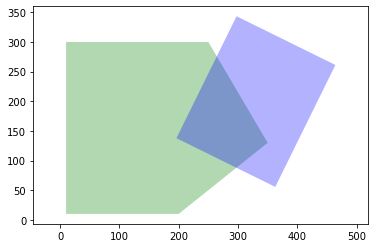

In [94]:
ag = optimizer.best_agent
sol = Rectangle(*ag['pos'])
print(ag['fit'])
print(sol.area())
print(optimizer.eval_func(ag['pos']))
draw_polygons([LAND, sol.to_rect()], colors=["green", "blue"])
sol.is_valid(LAND)

In [78]:
[Rectangle(*sol).area() for sol in init_function(20)]

[7184.9154788430915,
 4574.577485487954,
 8371.497519257004,
 5122.7283701996,
 3917.165914523459,
 7544.206321533536,
 2755.7855633698173,
 6124.241540973492,
 10237.567261692095,
 4485.355541963537,
 1384.5228827050732,
 2140.4745743483827,
 1317.559941098268,
 6695.491682345228,
 35566.19017593607,
 22515.39616841802,
 9514.42368684778,
 6076.764254927746,
 3513.9235692217007,
 8347.005330087462]